# Documentation

**Spencer Ressel**

**2023.06.14**

This code numerically solves the governing equations from Matsuno (1966). It was mostly written by Daniel Lloveras as a project for the course ATM S 582.  

The code uses the pseudospectral method with leapfrog time differencing to solve the equations of motion

# Imports

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import mjo_mean_state_diagnostics as mjo

# Define physical constants

In [92]:
GRAVITY = 9.81
EQUIVALENT_DEPTH = 250.
CORIOLIS_PARAMETER = 2.29e-11
EARTH_RADIUS = 6.4e6
METERS_PER_DEGREE = 110e3
SECONDS_PER_DAY = 86400
AIR_DENSITY = 1.225

gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)
time_scale = (CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)

print(f"Dry Gravity Wave Phase Speed: {gravity_wave_phase_speed:>10.2f} m/s")
print(f"Time Scale:                   {time_scale/SECONDS_PER_DAY:>10.2f} days")
print(f"Length Scale:                 {length_scale/1e3:>10.2f} km")

amplification_factor = {}

Dry Gravity Wave Phase Speed:      49.52 m/s
Time Scale:                         0.34 days
Length Scale:                    1470.57 km


# Define simulation parameters

In [104]:
# length scale for x domain in m
# zonal_domain_length = 12800e3
zonal_domain_length = 40000e3

# length of half y domain in m
meridional_domain_length = 5000e3

# length scale for heating in m
heating_length = zonal_domain_length/4

# x grid spacing in m
x_step_size = 200e3

# y grid spacing in m
# y_step_size = 1e5
y_step_size = 200e3

# time step in seconds
# time_step = int(cfl*x_step_size/gravity_wave_phase_speed)

# time length in days
n_days = 10
simulation_length = n_days*SECONDS_PER_DAY

# array of times
# time = np.arange(                                                
#     0,
#     simulation_length+time_step,
#     time_step
# )

time = np.linspace(
    0, 
    simulation_length, 
    2**13
)

time_step = np.diff(time)[0]

# x grid points 
x_grid = np.arange(                                               
    -zonal_domain_length/2,
    zonal_domain_length/2,
    x_step_size
)

# y grid points
y_grid = np.arange(                                               
    -meridional_domain_length,
    meridional_domain_length,
    y_step_size
)

# Specify points for quiver plotting
n_points = 10
x_plot_spacing = int((1/n_points/2)*zonal_domain_length/x_step_size)
y_plot_spacing = int((1/n_points)*2*meridional_domain_length/y_step_size)

# number of time steps
nt = len(time)

# number of x grid points
nx = len(x_grid)

# number of y grid points
ny = len(y_grid)

# zonal wavenumbers
zonal_wavenumber = 2*np.pi*fftfreq(nx,x_step_size)

# meridional wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny,y_step_size)

# frequencies
frequencies = 2*np.pi*fftfreq(nt, time_step)

CFL = gravity_wave_phase_speed*time_step/x_step_size

print(f"Lx = {zonal_domain_length/1e3:0.0f} km, Δx = {x_step_size/1e3:0.0f} km, nx = {nx:0.0f}")
print(f"Ly = {2*meridional_domain_length/1e3:0.0f} km, Δy = {y_step_size/1e3:0.0f} km, ny = {ny:0.0f}")
print(f"T = {simulation_length/SECONDS_PER_DAY:0.1f} days, Δt = {time_step:0.1f} seconds, nt = {nt:0.0f}")
print(f"CFL_x = {gravity_wave_phase_speed*time_step/x_step_size:0.3f}")
print(f"CFL_y = {gravity_wave_phase_speed*time_step/y_step_size:0.3f}")
if (gravity_wave_phase_speed*time_step/x_step_size > 1/(np.sqrt(2)*np.pi)):
    print("CFL > 1, numerically unstable!!")

Lx = 40000 km, Δx = 200 km, nx = 200
Ly = 10000 km, Δy = 200 km, ny = 50
T = 10.0 days, Δt = 105.5 seconds, nt = 8192
CFL_x = 0.026
CFL_y = 0.026


# Compute solutions

## Initial Conditions

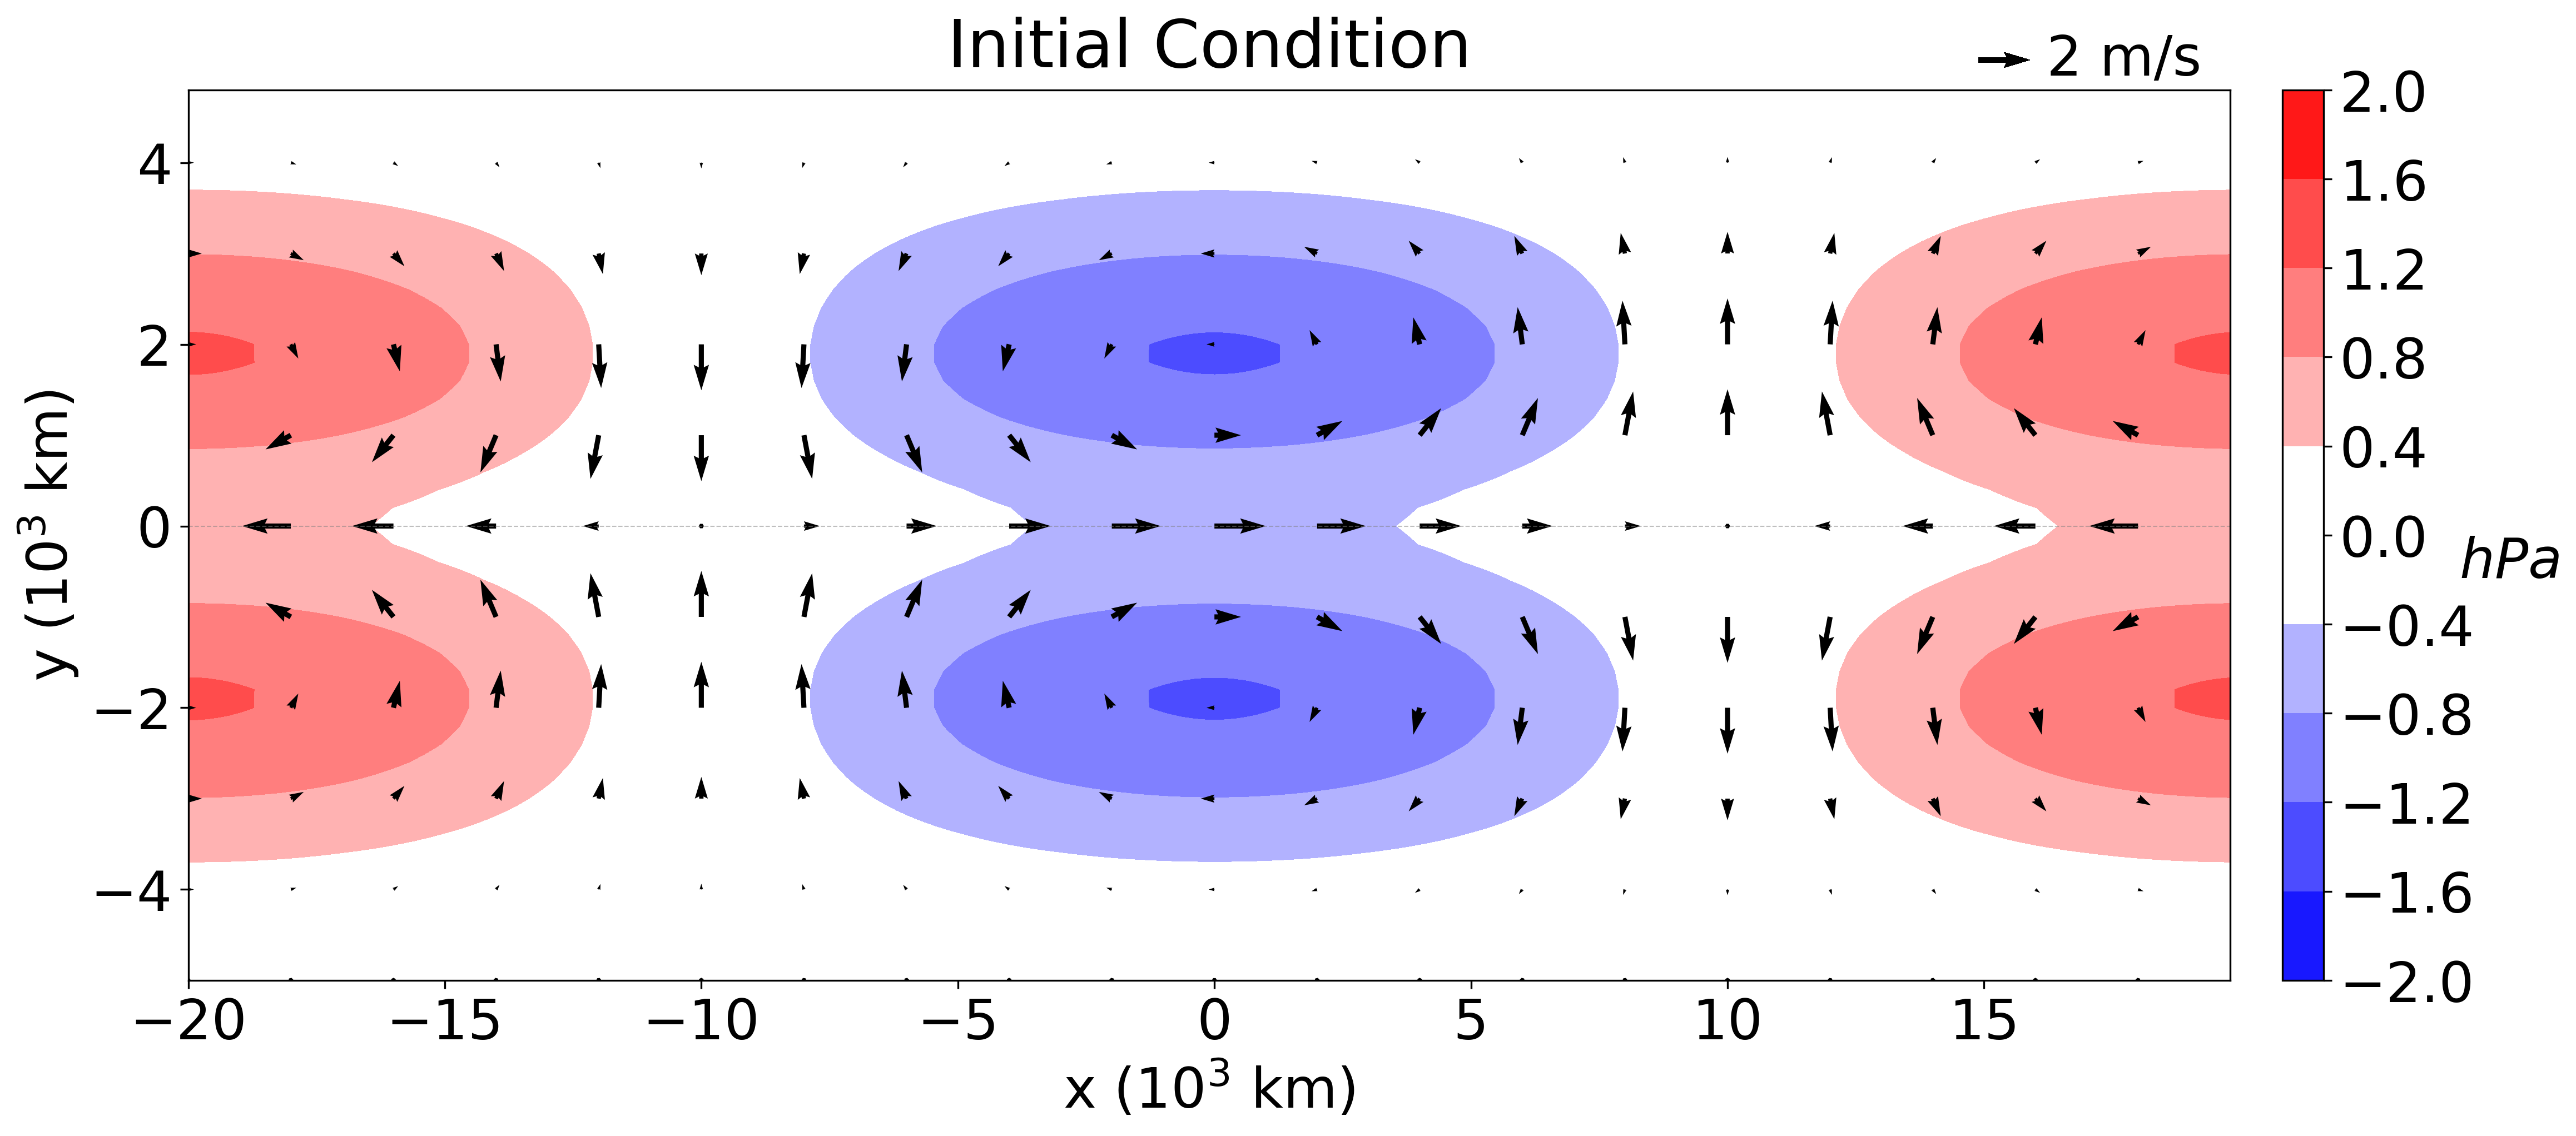

In [207]:
initial_wave = 'Rossby'
# initial_wave = 'single-perturbation'
initial_wavenumber = 1
initial_geopotential_anomaly = 100
mode_number = 1

def pcf(y, order):
    from scipy import special
    poly = special.hermite(order)
    return poly(y)*np.exp(-y**2/2)

y_hat = y_grid/length_scale

### Initialize arrays
zonal_velocity = np.zeros((nt,ny,nx))
meridional_velocity = np.zeros((nt,ny,nx))
geopotential_height = np.zeros((nt,ny,nx))

if initial_wave == 'single-perturbation':
    # Single perturbation
    geopotential_height[0] = gravity_wave_phase_speed*np.einsum(
            'i,j->ij',
            np.exp(-y_hat**2/2),
            np.cos(2*np.pi*initial_wavenumber*x_grid/zonal_domain_length)
    )
    geopotential_height[0, :, np.abs(x_grid) > zonal_domain_length/4] = 0
    geopotential_height[geopotential_height < 0] = 0

elif initial_wave == 'Kelvin':
    #### Kelvin wave initial condition ####
    # zonal_velocity[0] = gravity_wave_phase_speed*np.einsum(
    #     'i,j->ij',
    #     np.exp(-y_hat**2/2),
    #     np.cos(2*np.pi*initial_wavenumber*x_grid/zonal_domain_length)
    # )

    geopotential_height[0] = initial_geopotential_anomaly*np.einsum(
        'i,j->ij',
        np.exp(-y_hat**2/2),
        np.cos(2*np.pi*initial_wavenumber*x_grid/zonal_domain_length)
    )
    
    zonal_velocity[0] = np.copy(geopotential_height[0])/gravity_wave_phase_speed
    
elif initial_wave == 'Rossby':
    #### Rossby Wave Initial Condition ####
    initial_frequency = initial_wavenumber/(initial_wavenumber**2 + 2*mode_number +1)
    
    meridional_velocity[0] = np.real(
        np.einsum(
            'i,j->ij',
            1j*(initial_frequency**2 - initial_wavenumber**2)*pcf(y_hat, mode_number),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid) 
            + 1j*np.sin((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )

    zonal_velocity[0] = np.real(
        np.einsum(
            'i,j->ij',
                      0.5*(initial_frequency - initial_wavenumber)*pcf(y_hat, mode_number + 1) 
            + mode_number*(initial_frequency + initial_wavenumber)*pcf(y_hat, mode_number - 1),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
            + 1j*np.sin((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )

    geopotential_height[0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ij',
                      0.5*(initial_frequency - initial_wavenumber)*pcf(y_hat, mode_number + 1) 
            - mode_number*(initial_frequency + initial_wavenumber)*pcf(y_hat, mode_number - 1),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
            + 1j*np.sin((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )
    
    geopotential_height[0] = (initial_geopotential_anomaly/np.max(geopotential_height[0]))*geopotential_height[0]
    zonal_velocity[0] = (initial_geopotential_anomaly/np.max(geopotential_height[0]))*zonal_velocity[0]
    meridional_velocity[0] = (initial_geopotential_anomaly/np.max(geopotential_height[0]))*meridional_velocity[0]
    
elif initial_wave == 'EIG':
    #### EIG Initial Condition ####
    initial_frequency = -np.sqrt(initial_wavenumber**2 + 2*mode_number + 1)
    
    meridional_velocity[0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ij',
            1j*(initial_frequency**2 - initial_wavenumber**2)*pcf(y_hat, mode_number),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid) 
            + 1j*np.sin((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )

    zonal_velocity[0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ij',
                      0.5*(initial_frequency - initial_wavenumber)*pcf(y_hat, mode_number + 1) 
            + mode_number*(initial_frequency + initial_wavenumber)*pcf(y_hat, mode_number - 1),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )

    geopotential_height[0] = gravity_wave_phase_speed**2*np.real(
        np.einsum(
            'i,j->ij',
                      0.5*(initial_frequency - initial_wavenumber)*pcf(y_hat, mode_number + 1) 
            - mode_number*(initial_frequency + initial_wavenumber)*pcf(y_hat, mode_number - 1),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )
    
elif initial_wave == 'WIG':
    #### WIG Initial Condition ####
    initial_frequency = np.sqrt(initial_wavenumber**2 + 2*mode_number + 1)
    
    meridional_velocity[0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ij',
            1j*(initial_frequency**2 - initial_wavenumber**2)*pcf(y_hat, mode_number),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid) 
            + 1j*np.sin((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )

    zonal_velocity[0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ij',
                      0.5*(initial_frequency - initial_wavenumber)*pcf(y_hat, mode_number + 1) 
            + mode_number*(initial_frequency + initial_wavenumber)*pcf(y_hat, mode_number - 1),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )

    geopotential_height[0] = gravity_wave_phase_speed**2*np.real(
        np.einsum(
            'i,j->ij',
                      0.5*(initial_frequency - initial_wavenumber)*pcf(y_hat, mode_number + 1) 
            - mode_number*(initial_frequency + initial_wavenumber)*pcf(y_hat, mode_number - 1),
            np.cos((2*np.pi*initial_wavenumber/zonal_domain_length)*x_grid)
        )
    )
#################################

#### Plot initial conditions ####
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
plt.style.use('default')
plt.rcParams.update({'font.size':24})

# Calculate the equivalent pressure anomaly in hPa
equivalent_pressure = np.copy(geopotential_height)*AIR_DENSITY/100

# contour_scale = int(np.ceil(np.max(geopotential_height[0])))
contour_scale = int(np.ceil(np.max(equivalent_pressure[0])))
quiver_scale = int(np.ceil(np.max(zonal_velocity[0])))
grid_scaling = 1e-6

contour_args = {
    'levels' :  np.linspace(
                    -contour_scale, 
                    contour_scale, 
                    11
                ),
    # 'levels' :  11,
    'norm'   :  mcolors.CenteredNorm(),
    'cmap'   :  modified_cmap, 
    # 'extend' :  'both'
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.99, bottom=0.1, wspace=0.05)

cbar_ax = fig.add_subplot(gs[-1])
ax = fig.add_subplot(gs[0])

cont = ax.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    # geopotential_height[0],
    equivalent_pressure[0],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"$hPa$", rotation=0, labelpad=15)

quiv = ax.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[0,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[0,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 1.02,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.set_title('Initial Condition', pad=10)
ax.set_xlabel(r"x (10$^{3}$ km)")
ax.set_ylabel(r"y (10$^{3}$ km)")

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

ax.set_aspect('auto')
# ax.grid()

## Solve

In [208]:
### Initialize leapfrog method with one step forward

### Transform to wavenumber space
ux_fft = fft(zonal_velocity[0], axis=1)
vy_fft = fft(meridional_velocity[0], axis=0)
phix_fft = fft(geopotential_height[0], axis=1)
phiy_fft = fft(geopotential_height[0], axis=0)

### Compute derivatives
dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
dphidx_fft = 1j*zonal_wavenumber[None,:]*phix_fft
dphidy_fft = 1j*meridional_wavenumber[:,None]*phiy_fft
    
### Transform back to physical space
dudx = np.real(ifft(dudx_fft,axis=1))
dvdy = np.real(ifft(dvdy_fft,axis=0))
dphidx = np.real(ifft(dphidx_fft,axis=1))
dphidy = np.real(ifft(dphidy_fft,axis=0))

### Step forward one time step
zonal_velocity[1] = zonal_velocity[0] - time_step*(
    - CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[0] 
    + dphidx
)

meridional_velocity[1] =  meridional_velocity[0] - time_step*(
    + CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[0] 
    + dphidy
)

geopotential_height[1] = geopotential_height[0] - time_step*(
    gravity_wave_phase_speed**2*(dudx + dvdy) 
)

### Meridional boundary condition
meridional_velocity[1,0] = 0.
meridional_velocity[1,-1] = 0.

### Step forward using leapfrong time-differencing
for it in tqdm(range(2,nt), position=0, leave=True, ncols=100):
    ### Transform to spectral space
    ux_fft = fft(zonal_velocity[it-1], axis=1)
    vy_fft = fft(meridional_velocity[it-1], axis=0)
    phix_fft = fft(geopotential_height[it-1], axis=1)
    phiy_fft = fft(geopotential_height[it-1], axis=0)

    ### Compute derivatives
    dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    dphidx_fft = 1j*zonal_wavenumber[None,:]*phix_fft
    dphidy_fft = 1j*meridional_wavenumber[:,None]*phiy_fft

    ### Transform back to physical space
    dudx = np.real(ifft(dudx_fft, axis=1))
    dvdy = np.real(ifft(dvdy_fft, axis=0))
    dphidx = np.real(ifft(dphidx_fft, axis=1))
    dphidy = np.real(ifft(dphidy_fft, axis=0))

    ### Step forward with leapfrog scheme
    zonal_velocity[it] = zonal_velocity[it-2] - 2*time_step*(
            - CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[it-1] 
            + dphidx
        )
    
    meridional_velocity[it] = meridional_velocity[it-2] - 2*time_step*(
            + CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[it-1] 
            + dphidy
        )
    
    geopotential_height[it] = geopotential_height[it-2] - 2*time_step*(
            gravity_wave_phase_speed**2*(dudx + dvdy) 
        )

    
    ### Meridional boundary condition    
    meridional_velocity[it,0] = 0.
    meridional_velocity[it,-1] = 0.
    

100%|██████████████████████████████████████████████████████████| 8190/8190 [00:14<00:00, 565.16it/s]


# Simulation Output

## Plot solutions

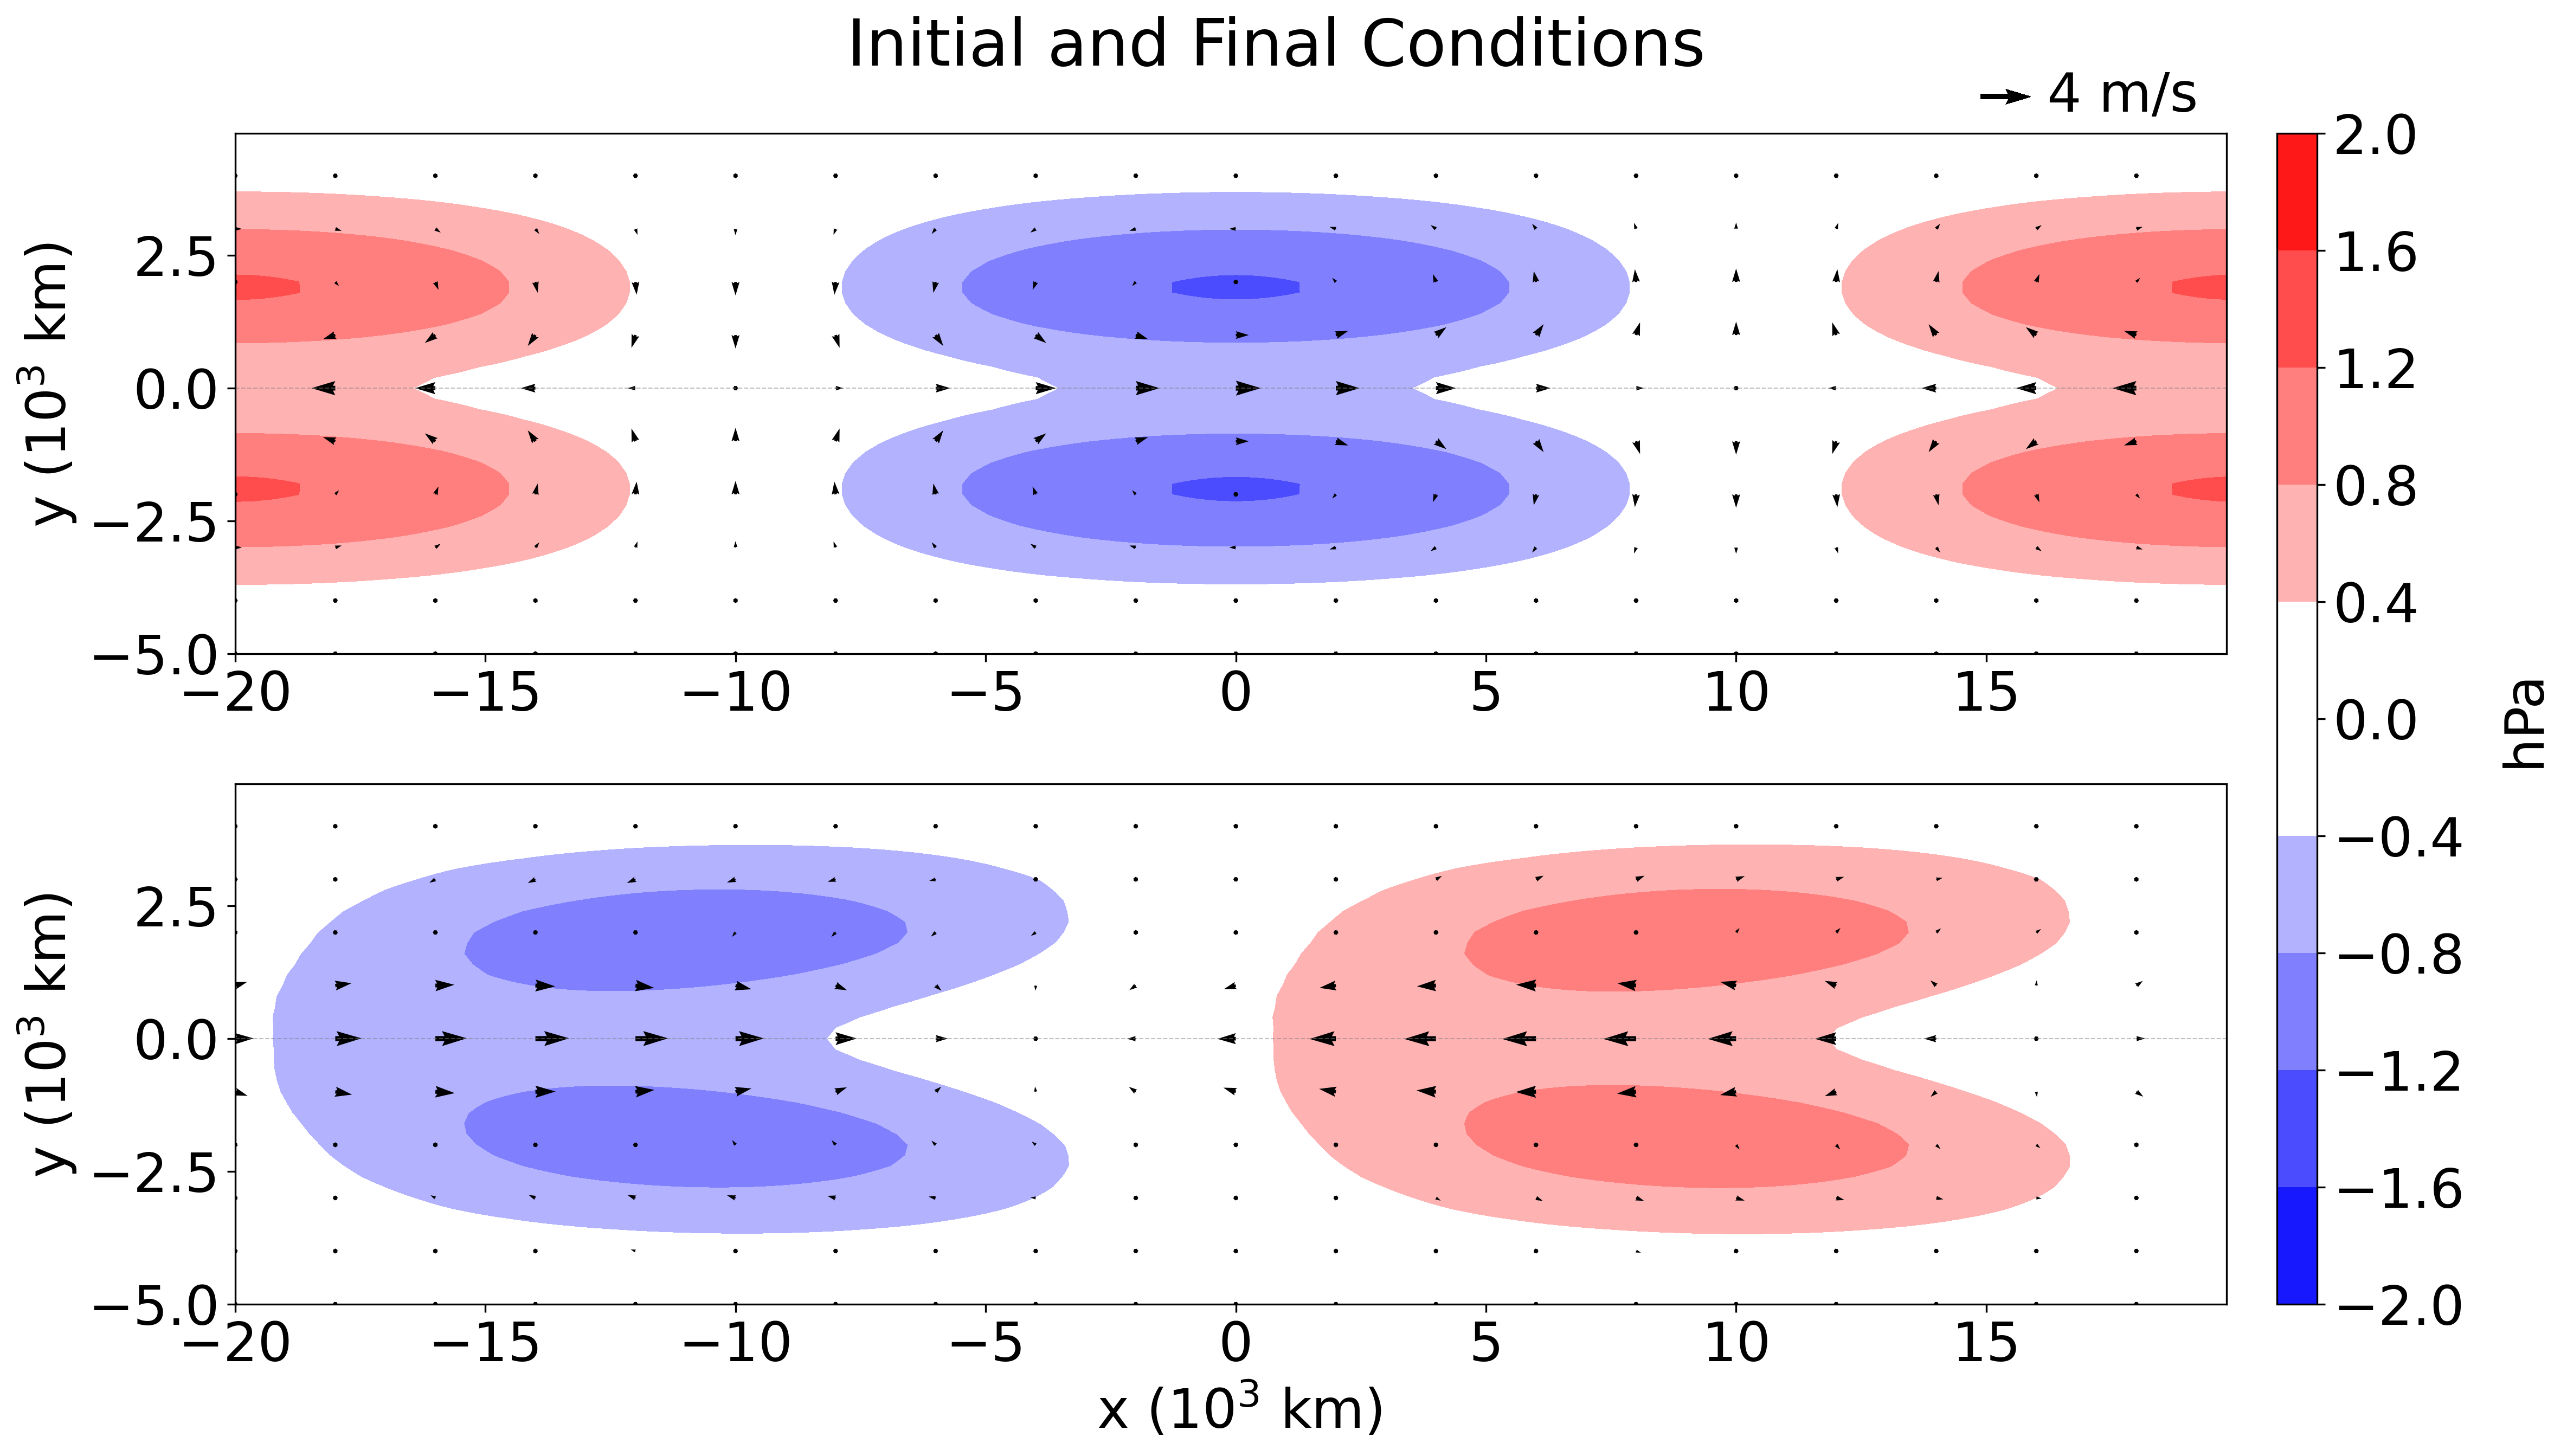

In [209]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

# Calculate the equivalent pressure perturbation in hPa
equivalent_pressure = np.copy(geopotential_height)*AIR_DENSITY/100
# contour_scale = int(np.ceil(np.max(geopotential_height)))
contour_scale = int(np.ceil(np.max(equivalent_pressure)))
quiver_scale = int(np.ceil(np.max(zonal_velocity)))
grid_scaling = 1e-6

end_frame = -1000

contour_args = {
    # 'levels' : np.arange(
    #                -np.around(gravity_wave_phase_speed, 0), 
    #                np.around(gravity_wave_phase_speed, 0)+10, 
    #                10
    #            ),
    'levels' : np.linspace(-contour_scale, contour_scale, 11),
    # 'levels' : 11, 
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    # 'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,9),dpi=300)
gs = GridSpec(2, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

# Label figure
fig.suptitle('Initial and Final Conditions')

#### Initial Condition ####
# Add for the initial condition
cbar_ax = fig.add_subplot(gs[:, -1])
ax0 = fig.add_subplot(gs[0, 0])

# Plot contours of geopotential height anomalies
cont = ax0.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    # geopotential_height[0],
    equivalent_pressure[0],
    **contour_args
)

cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"hPa", labelpad=15)

# Plot vectors of wind anomalies
quiv = ax0.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[0,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[0,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

# Add a key for the wind vectors
ax0.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line on the equator
ax0.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label y axis
ax0.set_ylabel(r" y (10$^{3}$ km)")

# Set the plot aspect
ax0.set_aspect('auto')
#########################

#### Final Condition ####
# Add axes for final condition
ax1 = fig.add_subplot(gs[1, 0])

# Geopotential Height contours
cont1 = ax1.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    # geopotential_height[end_frame],
    equivalent_pressure[end_frame],
    **contour_args
)

# Wind vectors
quiv1 = ax1.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[end_frame,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[end_frame,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

# Equator line
ax1.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label axes
ax1.set_xlabel(r" x (10$^{3}$ km)")
ax1.set_ylabel(r" y (10$^{3}$ km)")

# Aspect ratio
ax1.set_aspect('auto')

### Field Ratios

2.0210392379409012
97.19304561904542


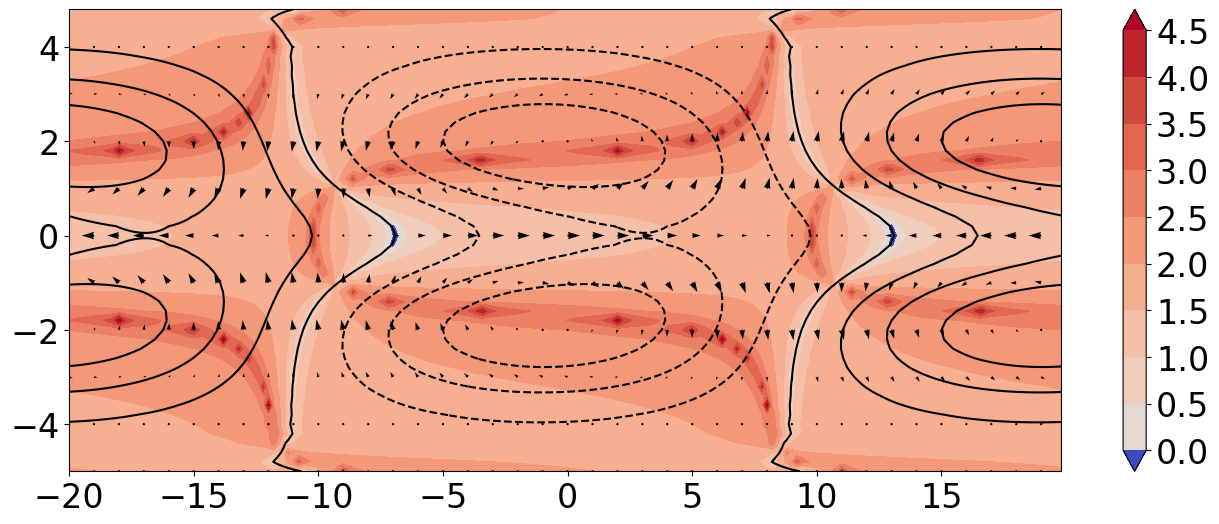

In [216]:
frame = 100

print(np.max(zonal_velocity[frame]))
print(np.max(geopotential_height[frame]))

plt.figure(figsize=(16,6))
plt.contourf(
    x_grid/1e6,
    y_grid/1e6,
    np.log10(np.abs(geopotential_height[frame]/zonal_velocity[frame])), 
    levels = 11,
    cmap='coolwarm', 
    norm=mcolors.CenteredNorm(vcenter=0),
    # norm=mcolors.LogNorm(),
    extend='both'
)
plt.colorbar()

plt.contour(
    x_grid/1e6,
    y_grid/1e6,
    geopotential_height[frame],
    colors='black'
)

plt.quiver(
    x_grid[::5]/1e6,
    y_grid[::5]/1e6,
    zonal_velocity[frame, ::5, ::5],
    meridional_velocity[frame, ::5, ::5],
    scale=int(np.ceil(np.max(zonal_velocity))),
    color='k',
    width=0.0025,
    angles='xy',
    scale_units='xy',
)
plt.show()

In [255]:
np.argmin(np.abs(zonal_velocity[0, 10:-10, 10]))
# plt.plot(y_grid/1e6, zonal_velocity[0,:,100]

6

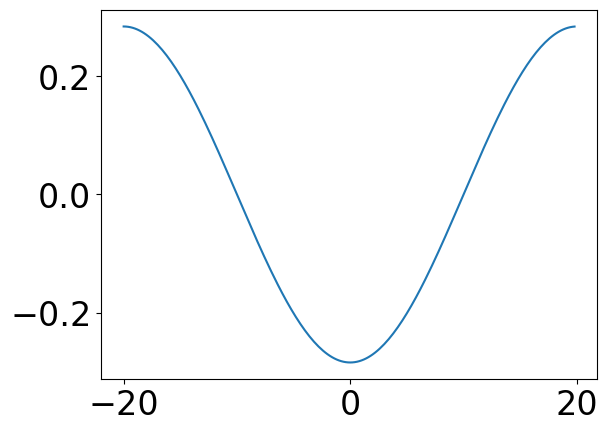

In [256]:
plt.plot(x_grid/1e6, zonal_velocity[0,6,:])

## Animate solutions

 98%|█████████████████████████████████████████████████████████████▊ | 50/51 [00:50<00:01,  1.55s/it]

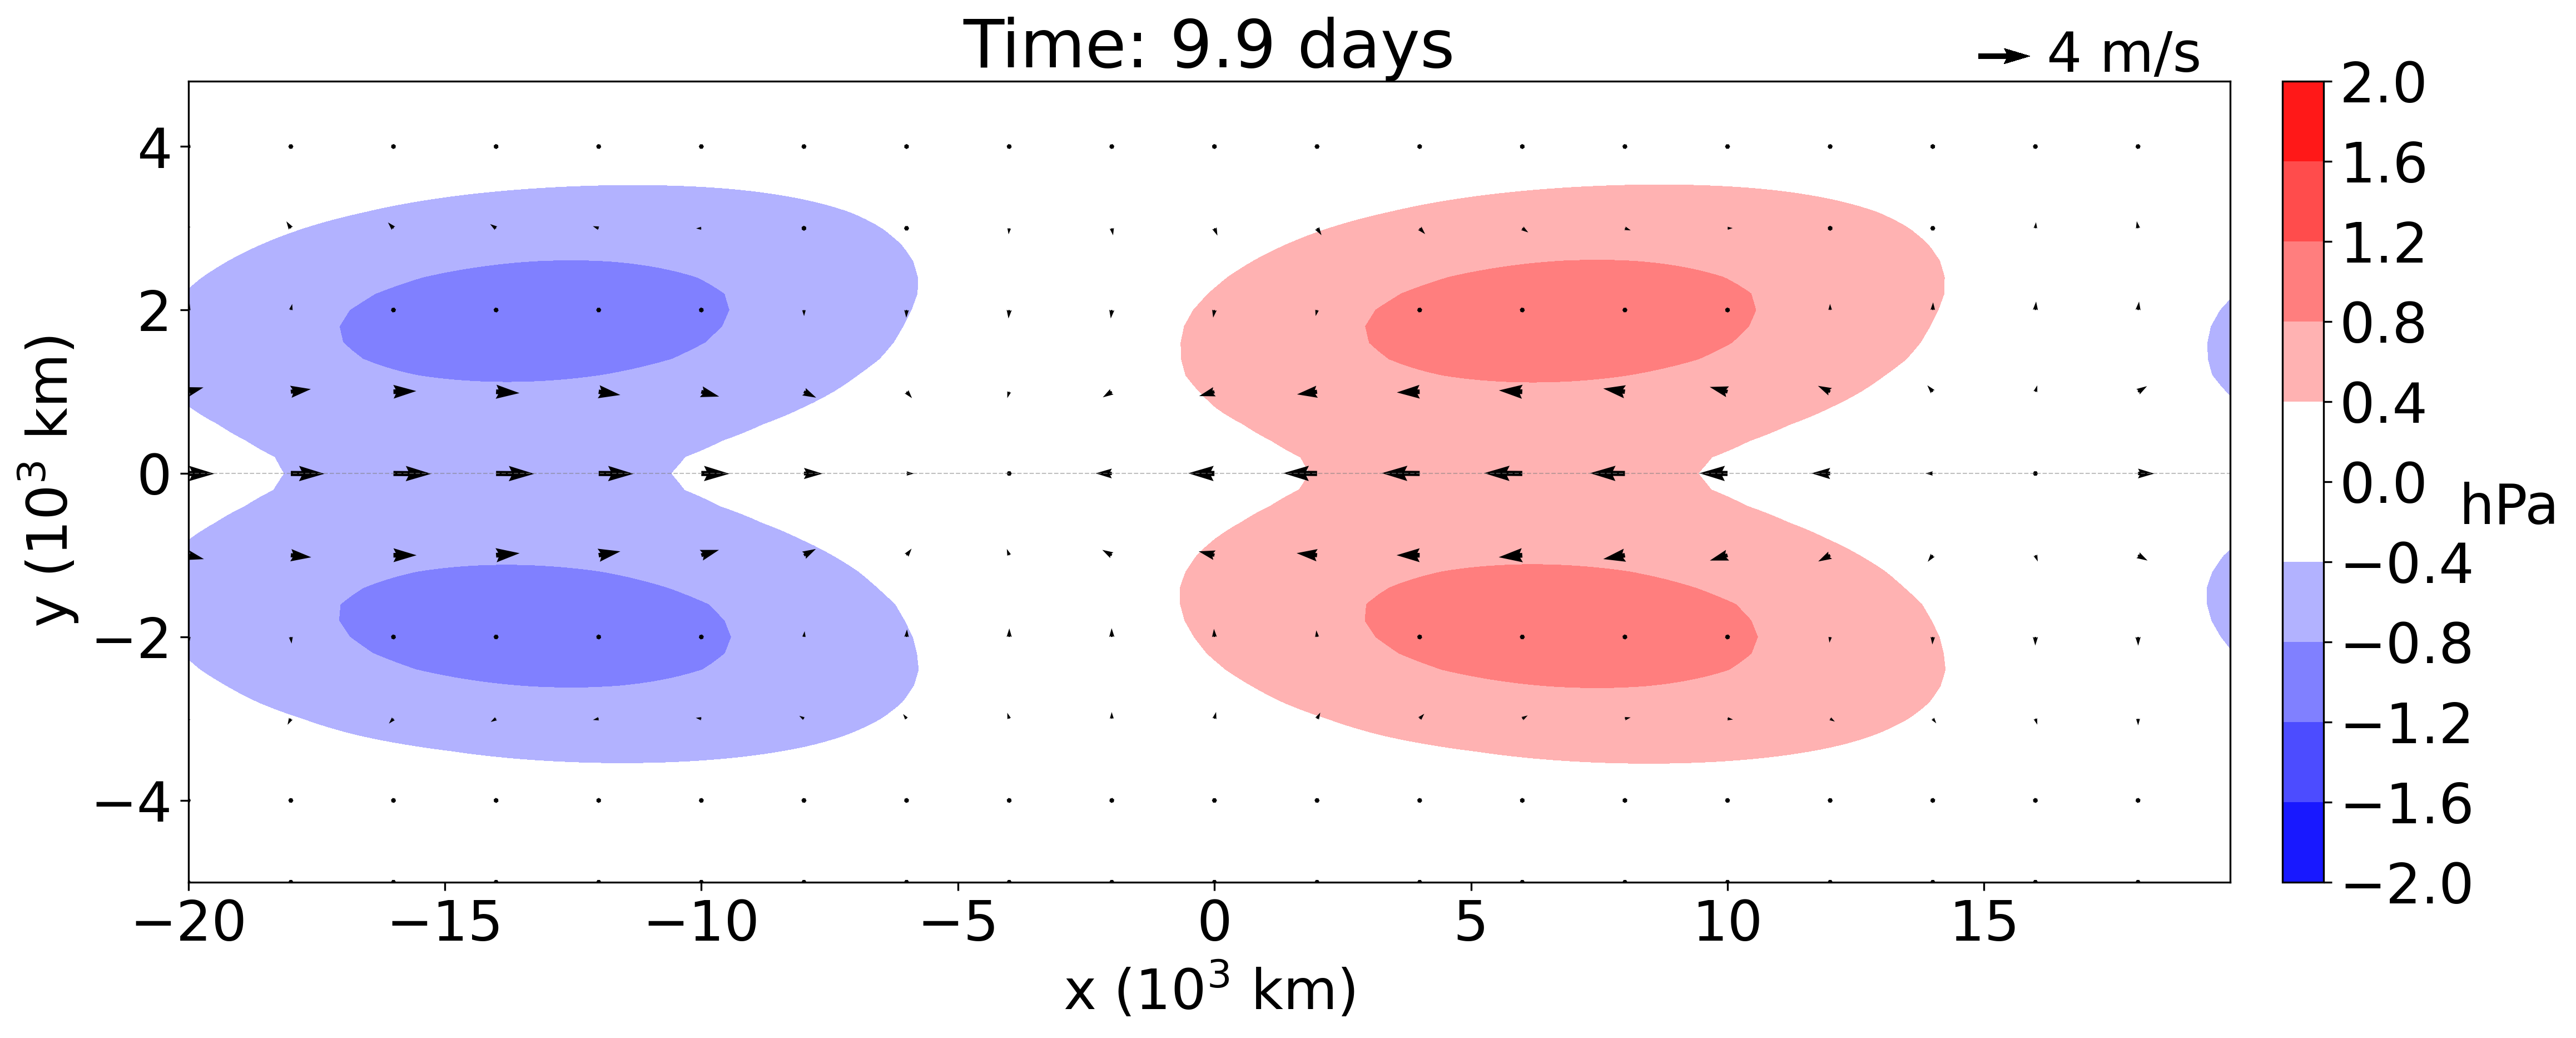

In [150]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})

n_frames = 50
starting_frame = 0
frame_interval = int((nt - starting_frame)/n_frames)
frames = np.arange(starting_frame, nt, frame_interval)

# Calculate equivalent pressure anomaly in hPa
equivalent_pressure = np.copy(geopotential_height)*AIR_DENSITY/100

contour_scale = int(np.ceil(np.max(equivalent_pressure)))
# contour_scale = int(np.ceil(np.max(geopotential_height)))
quiver_scale = int(np.ceil(np.max(zonal_velocity)))
grid_scaling = 1e-6

contour_args = {
    'levels' : np.linspace(-contour_scale, contour_scale, 11),
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    # 'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time[starting_frame]/SECONDS_PER_DAY:0.1f} days")

cont = ax.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    # geopotential_height[starting_frame],
    equivalent_pressure[starting_frame],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"hPa", rotation=0, labelpad=15)                    

quiv = ax.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[starting_frame,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[starting_frame,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('auto')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

def update(current_frame):
    
    # plotting_index = starting_frame + frame_interval*current_frame
    plotting_index = current_frame
    
    ax.set_title(f"Time: {time[plotting_index]/SECONDS_PER_DAY:0.1f} days")
    cont = ax.contourf(
        x_grid*grid_scaling,
        y_grid*grid_scaling,
        # geopotential_height[plotting_index],
        equivalent_pressure[plotting_index],
        **contour_args
    )
    quiv = ax.quiver(
        x_grid[::x_plot_spacing]*grid_scaling,
        y_grid[::y_plot_spacing]*grid_scaling,
        zonal_velocity[plotting_index,::y_plot_spacing,::x_plot_spacing],
        meridional_velocity[plotting_index,::y_plot_spacing,::x_plot_spacing],
        **quiver_args
    )
    return cont, quiv
    
anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

anim_dir = r"/home/disk/eos7/sressel/Research/Code/graphics/"
anim_file_name = f"dry_Matsuno_k={initial_wavenumber}_m={mode_number}_{initial_wave}_wave.mp4"
anim.save(anim_dir + anim_file_name, dpi=300)

## Filter Solutions

In [151]:
# Specify which wave type to plot
filtered_wave = 'Rossby'

# Filter period in days
filter_period = 5*SECONDS_PER_DAY

if filtered_wave == 'Kelvin' or filtered_wave == 'Rossby':
    time_filtered_zonal_velocity = mjo.butter_lowpass_filter(zonal_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_meridional_velocity = mjo.butter_lowpass_filter(meridional_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_geopotential_height = mjo.butter_lowpass_filter(geopotential_height.T, 1/filter_period, 1/time_step).T
    
elif filtered_wave == 'EIG' or filtered_wave == 'WIG':
    time_filtered_zonal_velocity = mjo.butter_highpass_filter(zonal_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_meridional_velocity = mjo.butter_highpass_filter(meridional_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_geopotential_height = mjo.butter_highpass_filter(geopotential_height.T, 1/filter_period, 1/time_step).T

print("Time Filtering Complete")
print("=======================")
# frequencies = np.fft.fftfreq(nt, time_step)
# phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(y_grid), axis=1)

# # Depending on the wave type specified, filter out waves propagating in the wrong direction
# if filtered_wave == 'Kelvin' or filtered_wave == 'EIG':
#     filter_condition = np.where(zonal_wavenumber != (2*np.pi)/zonal_domain_length)
#     # filter_condition = np.where(phase_speed <= 0)
    
# elif filtered_wave == 'Rossby' or filtered_wave == 'WIG':
#     filter_condition = np.where(phase_speed >= 0)
    
# zonal_velocity_fft = np.fft.fft2(time_filtered_zonal_velocity, axes=[0,2])
# zonal_velocity_fft[filter_condition] = 0+1j*0
# zonal_velocity_filtered = np.real(np.fft.ifft2(zonal_velocity_fft, axes=[0,2]))

# meridional_velocity_fft = np.fft.fft2(time_filtered_meridional_velocity, axes=[0,2])
# meridional_velocity_fft[filter_condition] = 0+1j*0
# meridional_velocity_filtered = np.real(np.fft.ifft2(meridional_velocity_fft, axes=[0,2]))

# geopotential_height_fft = np.fft.fft2(time_filtered_geopotential_height, axes=[0,2])
# geopotential_height_fft[filter_condition] = 0+1j*0
# geopotential_height_filtered = np.real(np.fft.ifft2(geopotential_height_fft, axes=[0,2]))

# print("Direction Filtering Complete")
# print("============================")

Time Filtering Complete


### Plot filtered solutions

 98%|█████████████████████████████████████████████████████████████▊ | 50/51 [09:02<00:10, 10.85s/it]


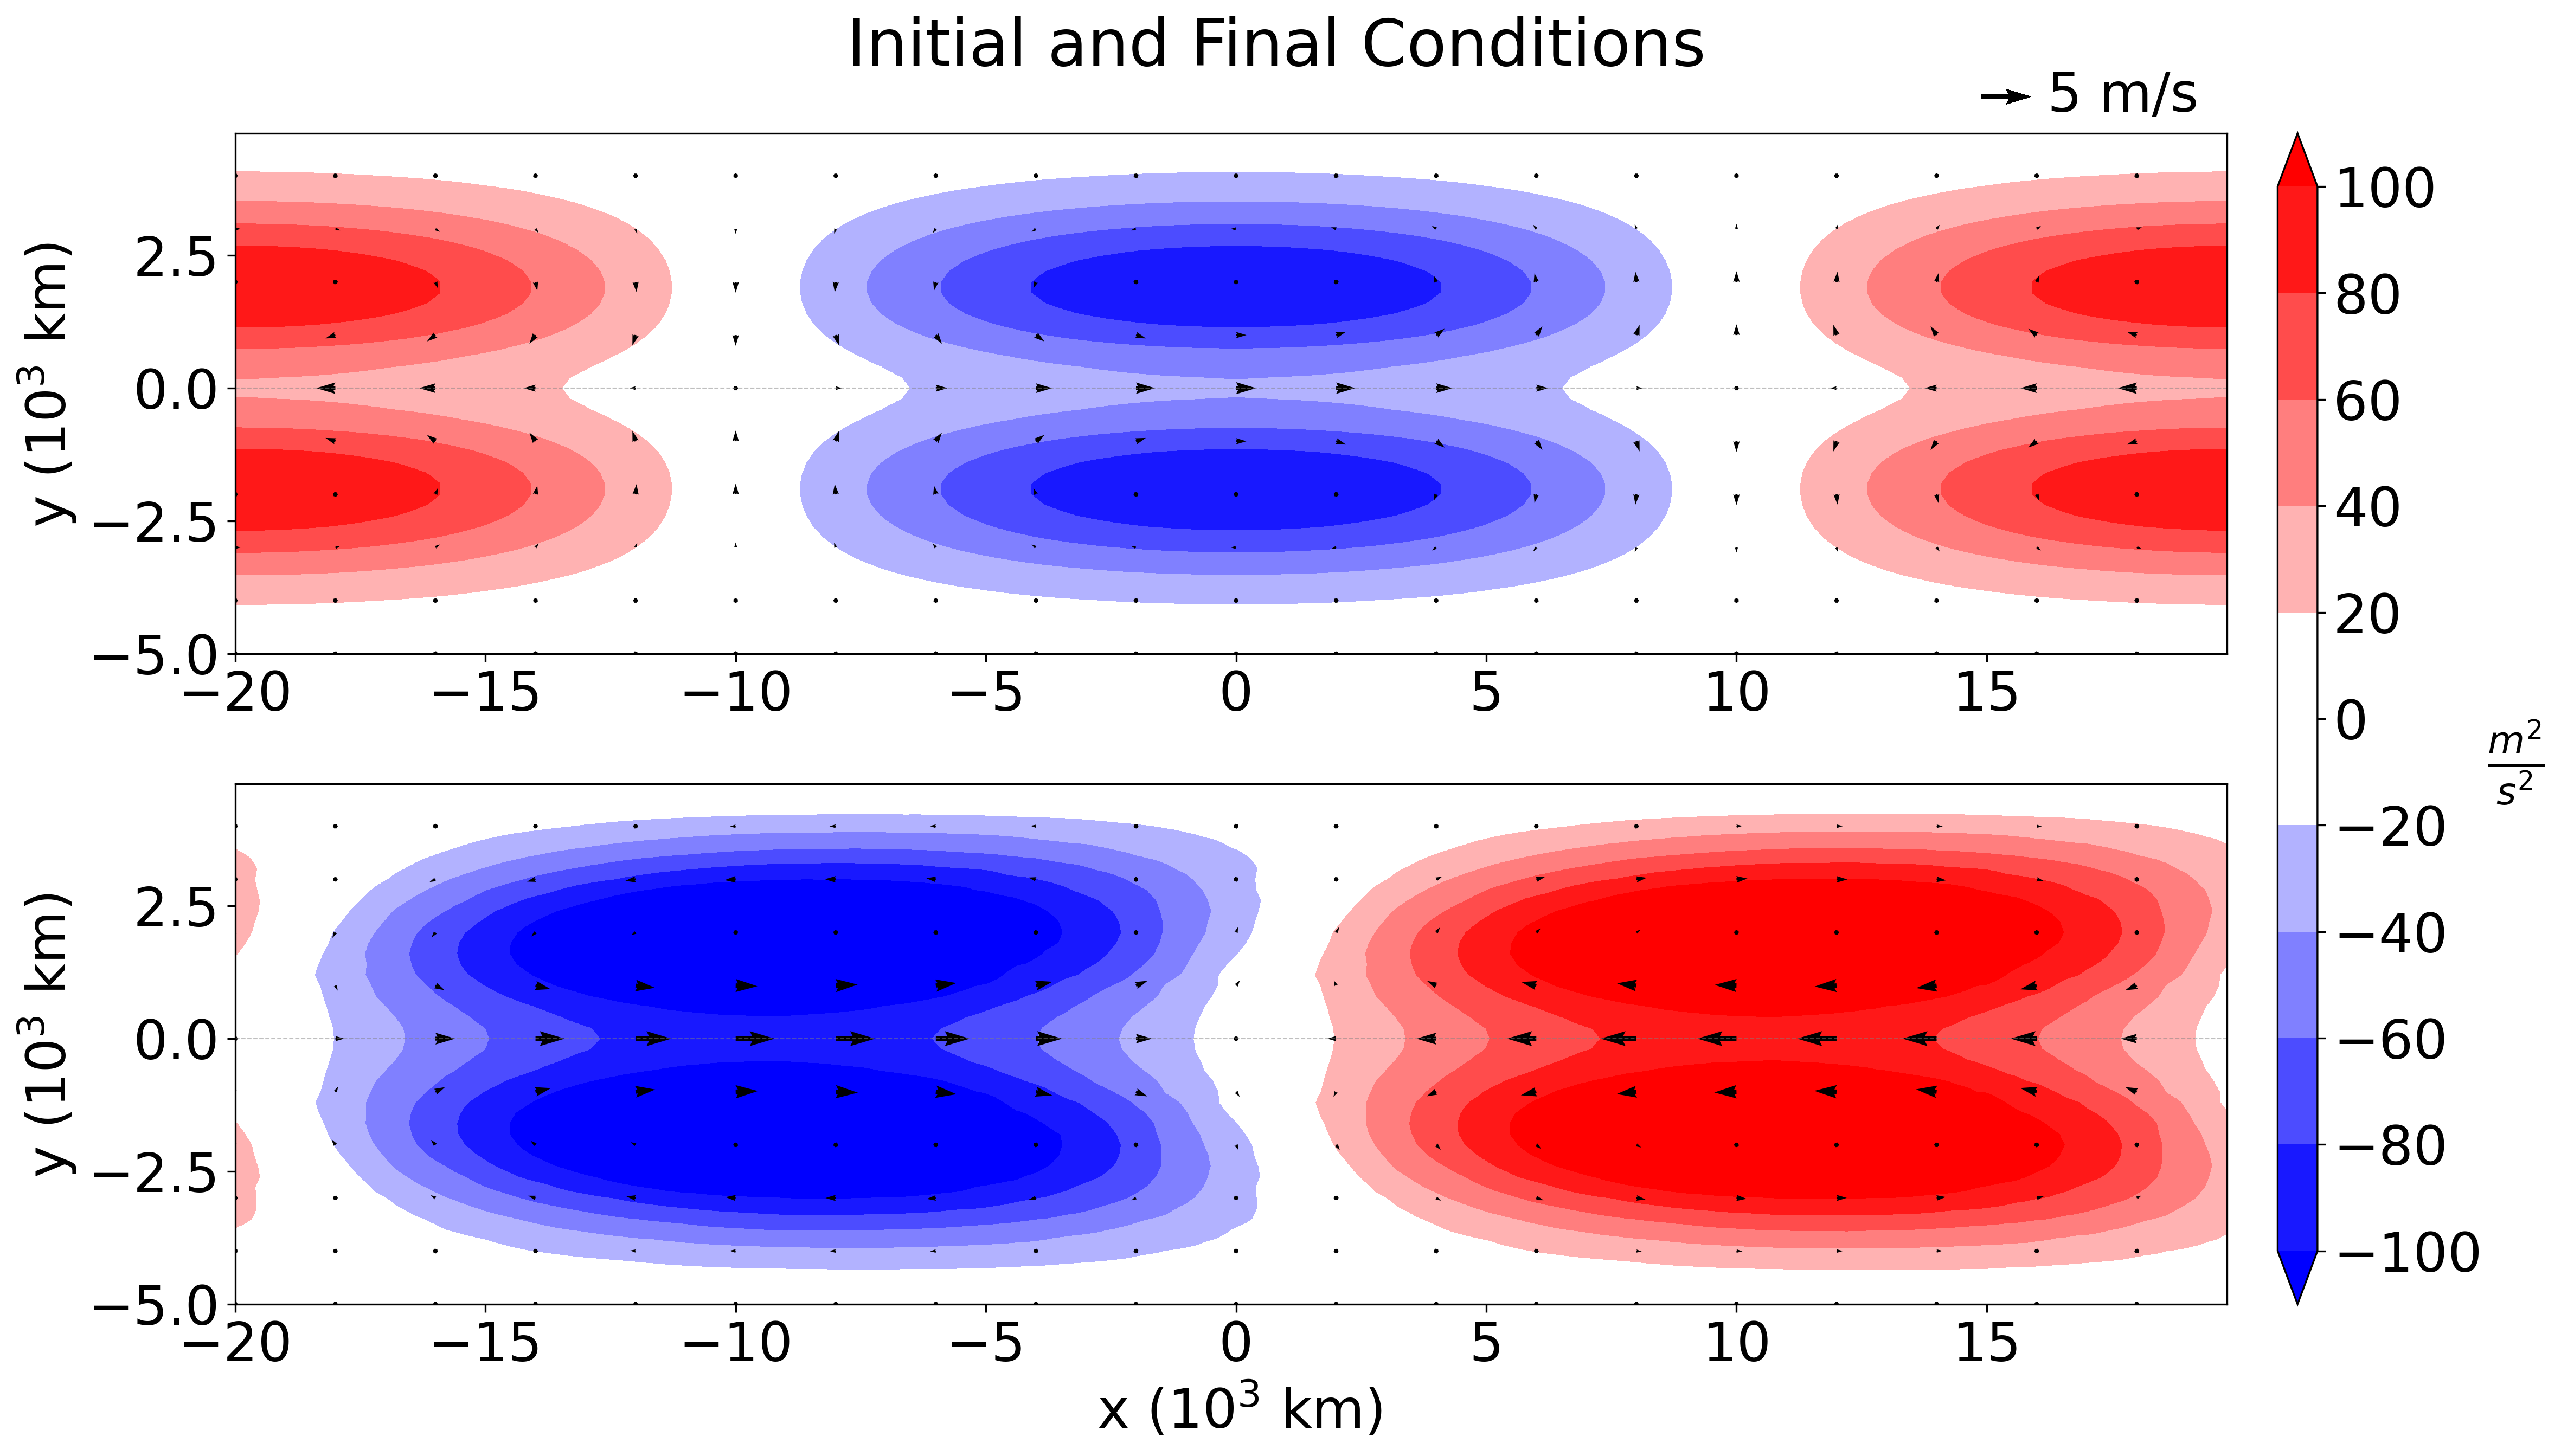

In [152]:
geopotential_height_filtered = time_filtered_geopotential_height
zonal_velocity_filtered = time_filtered_zonal_velocity
meridional_velocity_filtered = time_filtered_meridional_velocity

# Specify plotting parameters
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
grid_scaling = 1e-6
quiver_scale = int(np.ceil(np.max(zonal_velocity_filtered)))
end_frame = -1

contour_args = {
    # 'levels':np.linspace(-50,50,11),
    'levels' : np.linspace(np.min(geopotential_height), np.max(geopotential_height), 11),
    'norm':mcolors.CenteredNorm(),
    'cmap':modified_cmap, 
    'extend':'both'    
}

quiver_args = {
    'color':'k',
    'width':0.0025,
    'angles':'xy',
    'scale_units':'xy',
    'scale':quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,9),dpi=300)
gs = GridSpec(2, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

# Label figure
fig.suptitle('Initial and Final Conditions')

#### Initial Condition ####
# Add for the initial condition
cbar_ax = fig.add_subplot(gs[:, -1])
ax0 = fig.add_subplot(gs[0, 0])

# Plot contours of geopotential height anomalies
cont = ax0.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    geopotential_height[0],
    **contour_args

)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)

# Plot vectors of wind anomalies
quiv = ax0.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[0,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[0,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

# Add a key for the wind vectors
ax0.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line on the equator
ax0.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label y axis
ax0.set_ylabel(r" y (10$^{3}$ km)")

# Set the plot aspect
ax0.set_aspect('auto')
#########################

#### Final Condition ####
# Add axes for final condition
ax1 = fig.add_subplot(gs[1, 0])

# Geopotential Height contours
cont1 = ax1.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    geopotential_height_filtered[end_frame],
    **contour_args
)

# Wind vectors
quiv1 = ax1.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity_filtered[end_frame,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity_filtered[end_frame,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

# Equator line
ax1.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label axes
ax1.set_xlabel(r" x (10$^{3}$ km)")
ax1.set_ylabel(r" y (10$^{3}$ km)")

# Aspect ratio
ax1.set_aspect('auto')

### Animate filtered solutions

 98%|█████████████████████████████████████████████████████████████▊ | 50/51 [03:40<00:04,  4.40s/it]


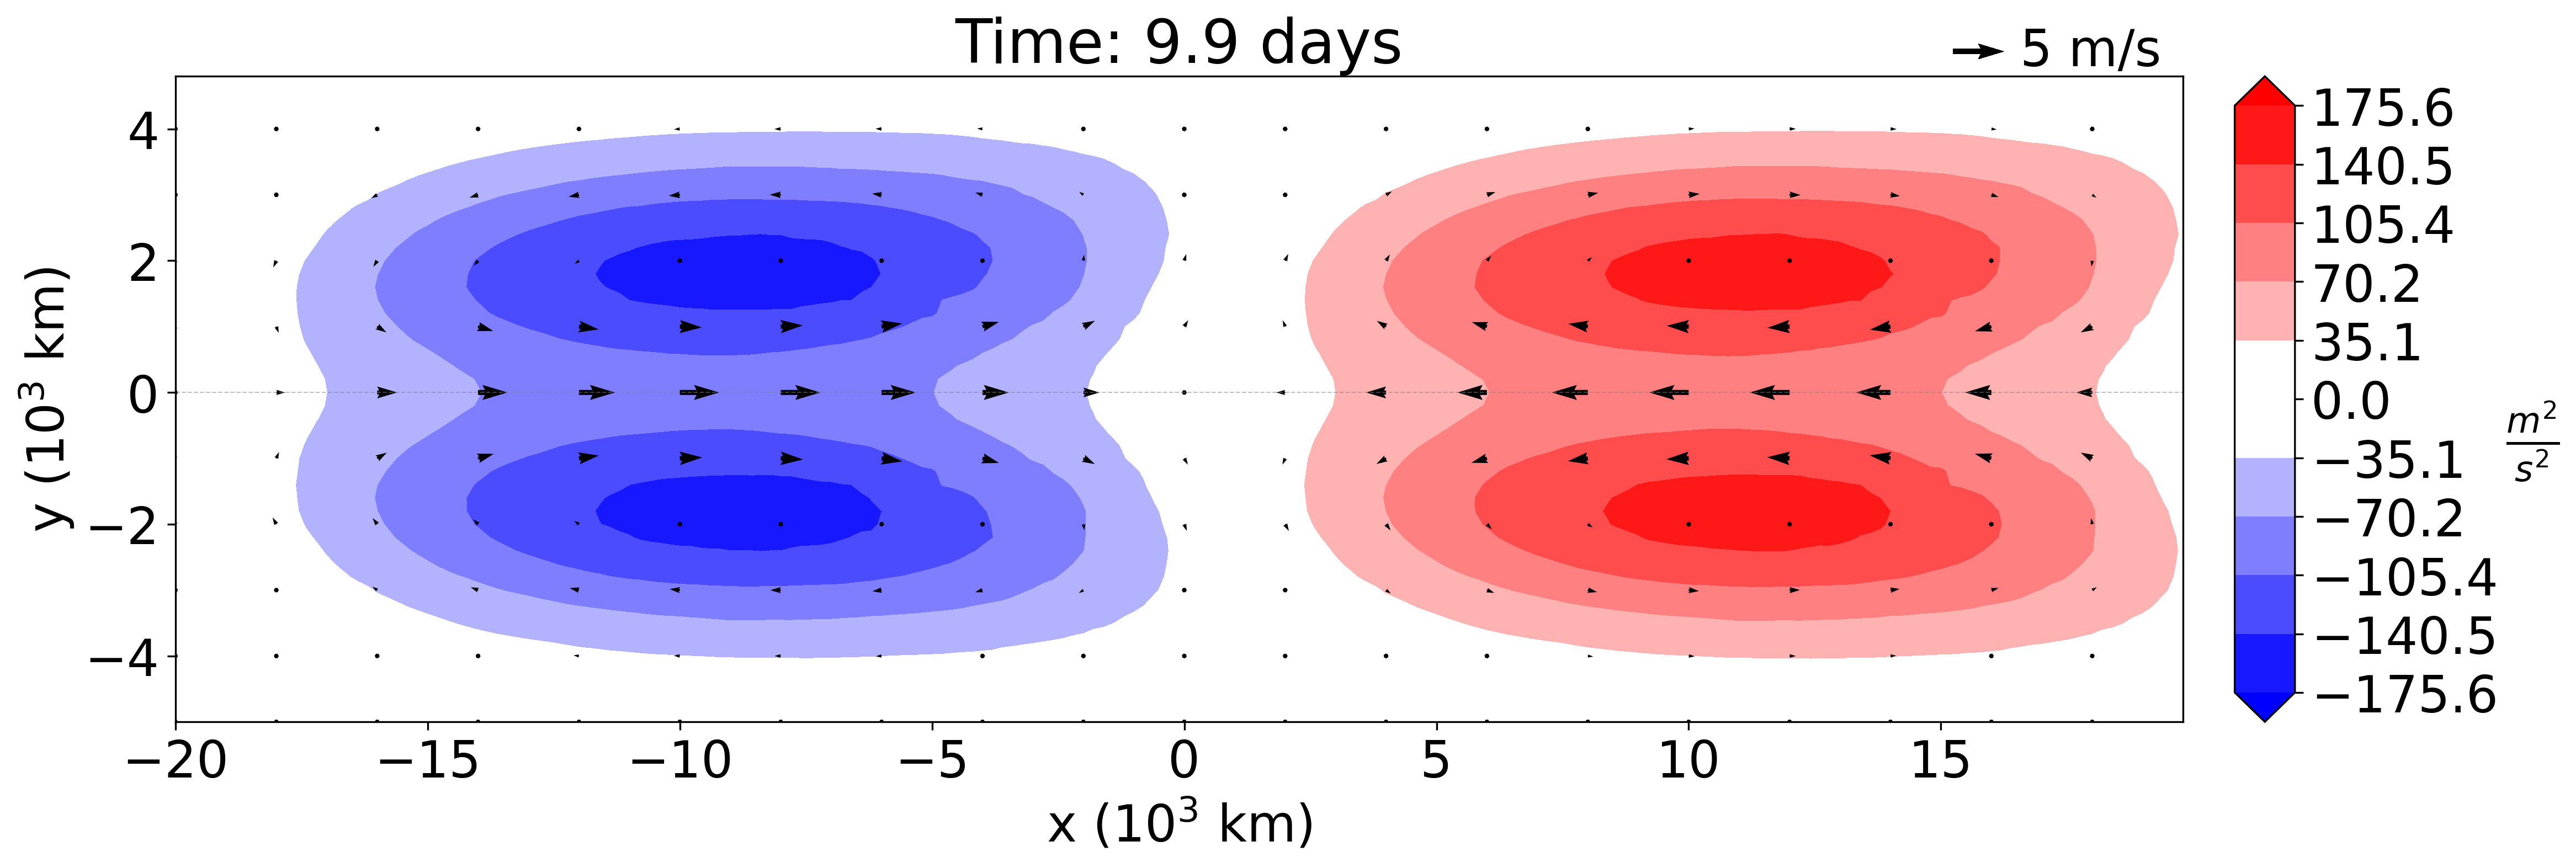

In [153]:
plt.style.use('default')
plt.rcParams.update({'font.size':22})

n_frames = 50
starting_frame = 0
frame_interval = int((nt - starting_frame)/n_frames)
frames = np.arange(starting_frame, nt, frame_interval)

contour_args = {
    # 'levels':np.linspace(-50,50,11),
    'levels' : np.linspace(-np.max(geopotential_height_filtered), np.max(geopotential_height_filtered), 11),
    'norm':mcolors.CenteredNorm(),
    'cmap':modified_cmap, 
    'extend':'both'    
}

quiver_args = {
    'color':'k',
    'width':0.0025,
    'angles':'xy',
    'scale_units':'xy',
    'scale':quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, figure=fig, width_ratios=[100,3])
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.25, wspace=0.05)
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time[starting_frame]/SECONDS_PER_DAY:0.1f} days")

cont = ax.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    geopotential_height_filtered[starting_frame],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)

quiv = ax.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity_filtered[starting_frame,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity_filtered[starting_frame,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('auto')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

def update(current_frame):
    
    # plotting_index = starting_frame + frame_interval*current_frame
    plotting_index = current_frame
    
    ax.set_title(f"Time: {time[plotting_index]/SECONDS_PER_DAY:0.1f} days")
    cont = ax.contourf(
        x_grid*grid_scaling,
        y_grid*grid_scaling,
        geopotential_height_filtered[plotting_index],
        **contour_args
    )
    quiv = ax.quiver(
        x_grid[::x_plot_spacing]*grid_scaling,
        y_grid[::y_plot_spacing]*grid_scaling,
        zonal_velocity_filtered[plotting_index,::y_plot_spacing,::x_plot_spacing],
        meridional_velocity_filtered[plotting_index,::y_plot_spacing,::x_plot_spacing],
        **quiver_args
    )
    
    return cont, quiv
    
anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

anim_dir = r"/home/disk/eos7/sressel/Research/Code/graphics/"
anim_file_name = r"dry_Matsuno_filtered_" + filtered_wave + "_wave.mp4"
anim.save(anim_dir + anim_file_name, dpi=300)

## Calculate amplification factor

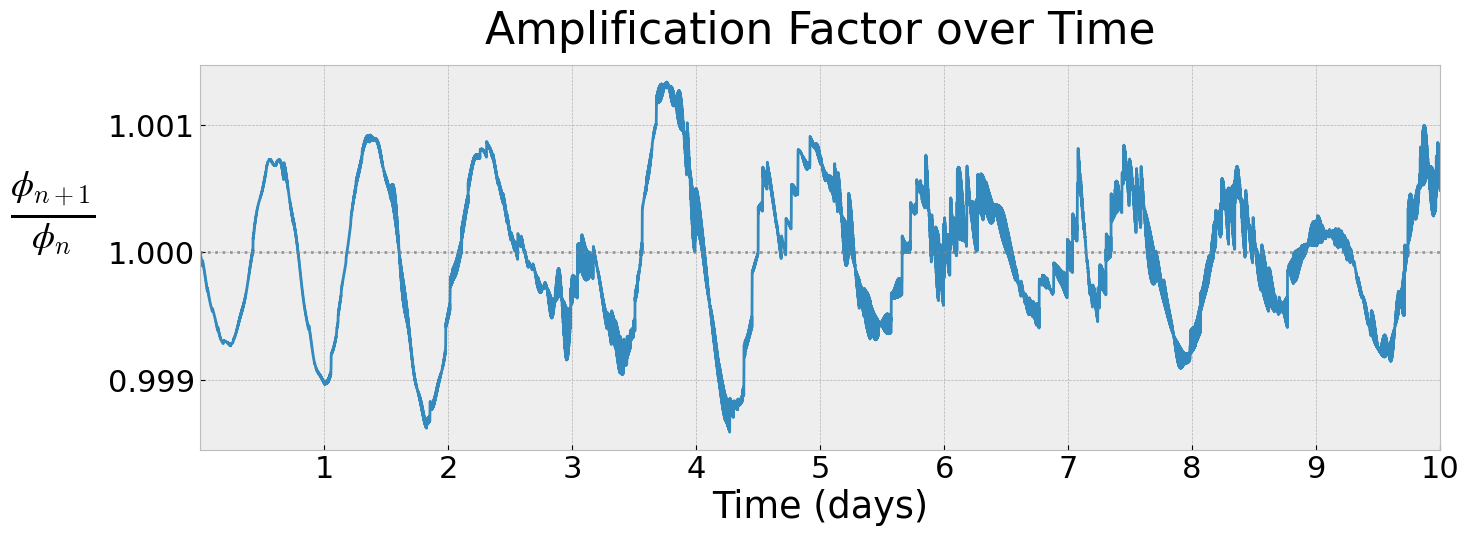

In [155]:
[y_max, x_max] = np.unravel_index(np.argmax(geopotential_height[0]), np.shape(geopotential_height[0]))
# amplification_factor = [geopotential_height[i, y_max, x_max]/geopotential_height[i-1, y_max, x_max] for i in range(1, nt)]
amplification_factor = [np.max(geopotential_height[i])/np.max(geopotential_height[i-1]) for i in range(1, nt)]


plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16,5))
ax.set_title('Amplification Factor over Time', pad=15)

ax.plot(
    time[1:]/SECONDS_PER_DAY, 
    amplification_factor
)

ax.axhline(y=1, color='gray', alpha=0.75, ls=':')

ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=n_days, prune='lower'))

ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{ϕ_{n+1}}{ϕ_{n}}$", rotation=0, labelpad=40, fontsize=38)
        
# ax.set_ylim(0.99, 1.01)
ax.set_xlim(0, n_days)
plt.show()

# Ahmed (2021) Solutions

## Physical Constants

In [1055]:
GRAVITY = 9.81
EQUIVALENT_DEPTH = 250.
CORIOLIS_PARAMETER = 2.29e-11
SECONDS_PER_DAY = 86400
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)
time_scale = (2*CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)
length_scale = (gravity_wave_phase_speed/(2*CORIOLIS_PARAMETER))**(1/2)

# Ahmed (2021) constants
gross_dry_stability = 3.12e4
gross_moisture_stratification = 0.75*gross_dry_stability
# moisture_sensitivity = 1/(6*3600)
# temperature_sensitivity = 1/(2*3600)
moisture_sensitivity = 0
temperature_sensitivity = 0
# cloud_radiative_parameter = 0.2
cloud_radiative_parameter = 0
zonal_moistening = 5e-4
meridional_moistening = 9e-10

## Simulation Parameters

In [1065]:
# Courant-Friedrichs-Lewy number
# cfl = 0.1

# length scale for x domain in m
zonal_domain_length = 40000e3

# length of half y domain in m
meridional_domain_length = 5e6

# length scale for heating in m
heating_length = zonal_domain_length/4

# x grid spacing in m
x_step_size = 2e5

# y grid spacing in m
# y_step_size = 1e5
y_step_size = 2e5

# time step in seconds
# time_step = int(cfl*x_step_size/gravity_wave_phase_speed)

# time length in days
n_days = 10
simulation_length = n_days*SECONDS_PER_DAY

# array of times
# time = np.arange(                                                
#     0,
#     simulation_length+time_step,
#     time_step
# )

time = np.linspace(
    0, 
    simulation_length, 
    2**13
)

time_step = np.diff(time)[0]

# x grid points 
# x grid points 
x_grid = np.arange(                                               
    -zonal_domain_length/2,
    zonal_domain_length/2,
    x_step_size
)

# y grid points
y_grid = np.arange(                                               
    -meridional_domain_length,
    meridional_domain_length,
    y_step_size
)

# Specify points for quiver plotting
n_points = 10
x_plot_spacing = int((1/n_points/2)*zonal_domain_length/x_step_size)
y_plot_spacing = int((1/n_points)*2*meridional_domain_length/y_step_size)


# number of time steps
nt = len(time)

# number of x grid points
nx = len(x_grid)

# number of y grid points
ny = len(y_grid)

# zonal wavenumbers
zonal_wavenumber = 2*np.pi*fftfreq(nx,x_step_size)

# meridional wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny,y_step_size)

# frequencies
frequencies = 2*np.pi*fftfreq(nt, time_step)

print(f"Lx = {zonal_domain_length/1e3:0.0f} km, Δx = {x_step_size/1e3:0.0f} km, nx = {nx:0.0f}")
print(f"Ly = {2*meridional_domain_length/1e3:0.0f} km, Δy = {y_step_size/1e3:0.0f} km, ny = {ny:0.0f}")
print(f"T = {simulation_length/SECONDS_PER_DAY:0.1f} days, Δt = {time_step:0.1f} seconds, nt = {nt:0.0f}")
print(f"CFL = {gravity_wave_phase_speed*time_step/x_step_size:0.2f}")
if (gravity_wave_phase_speed*time_step/x_step_size > 1):
    print("CFL > 1, numerically unstable!!")

Lx = 40000 km, Δx = 200 km, nx = 200
Ly = 10000 km, Δy = 200 km, ny = 50
T = 10.0 days, Δt = 105.5 seconds, nt = 8192
CFL = 0.03


## Initial Conditions

In [1079]:
### Initialize arrays
zonal_velocity = np.zeros((nt,ny,nx))
meridional_velocity = np.zeros((nt,ny,nx))
column_temperature = np.zeros((nt,ny,nx))
column_moisture = np.zeros((nt, ny,nx))

# zonal_velocity[0,:,:] = -np.einsum(
#     'i,j->ij',
#     (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.sin((np.pi*x_grid)/(2*heating_length))
# )
# zonal_velocity[0,:,:][:, np.abs(x_grid) > 2*heating_length] = 0

# meridional_velocity[0,:,:] = np.einsum(
#     'i,j->ij',
#     (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.cos((np.pi*x_grid)/(2*heating_length))
# )
# meridional_velocity[0,:,:][:, np.abs(x_grid) > heating_length] = 0

# column_temperature[0,:,:] = np.einsum(
#     'i,j->ij',
#     # (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.exp(-y_grid**2/(4*length_scale**2)),
#     np.sin((np.pi*x_grid)/(2*heating_length))
# )
# column_temperature[0,:,:][:, np.abs(x_grid) > 2*heating_length] = 0

# column_moisture[0,:,:] = np.einsum(
#     'i,j->ij',
#     # (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.exp(-y_grid**2/(4*length_scale**2)),
#     np.sin((np.pi*x_grid)/(2*heating_length))
# )
# column_moisture[0,:,:][:, np.abs(x_grid) > heating_length] = 0

initial_wave = 'Kelvin'
initial_wavenumber = 1
mode_number = 1

def pcf(y, order):
    from scipy import special
    poly = special.hermite(order)
    return poly(y)*np.exp(-y**2/2)

y_hat = y_grid/length_scale

### Initialize arrays
zonal_velocity = np.zeros((nt,ny,nx))
meridional_velocity = np.zeros((nt,ny,nx))
column_temperature = np.zeros((nt,ny,nx))

#### Kelvin wave initial condition ####
zonal_velocity[0] = np.einsum(
    'i,j->ij',
    np.exp(-y_hat**2/2),
    np.cos(2*np.pi*initial_wavenumber*x_grid/zonal_domain_length)
)

column_temperature[0] = gross_dry_stability/gravity_wave_phase_speed*np.einsum(
    'i,j->ij',
    np.exp(-y_hat**2/2),
    np.cos(2*np.pi*initial_wavenumber*x_grid/zonal_domain_length)
)

### Plot initial conditions

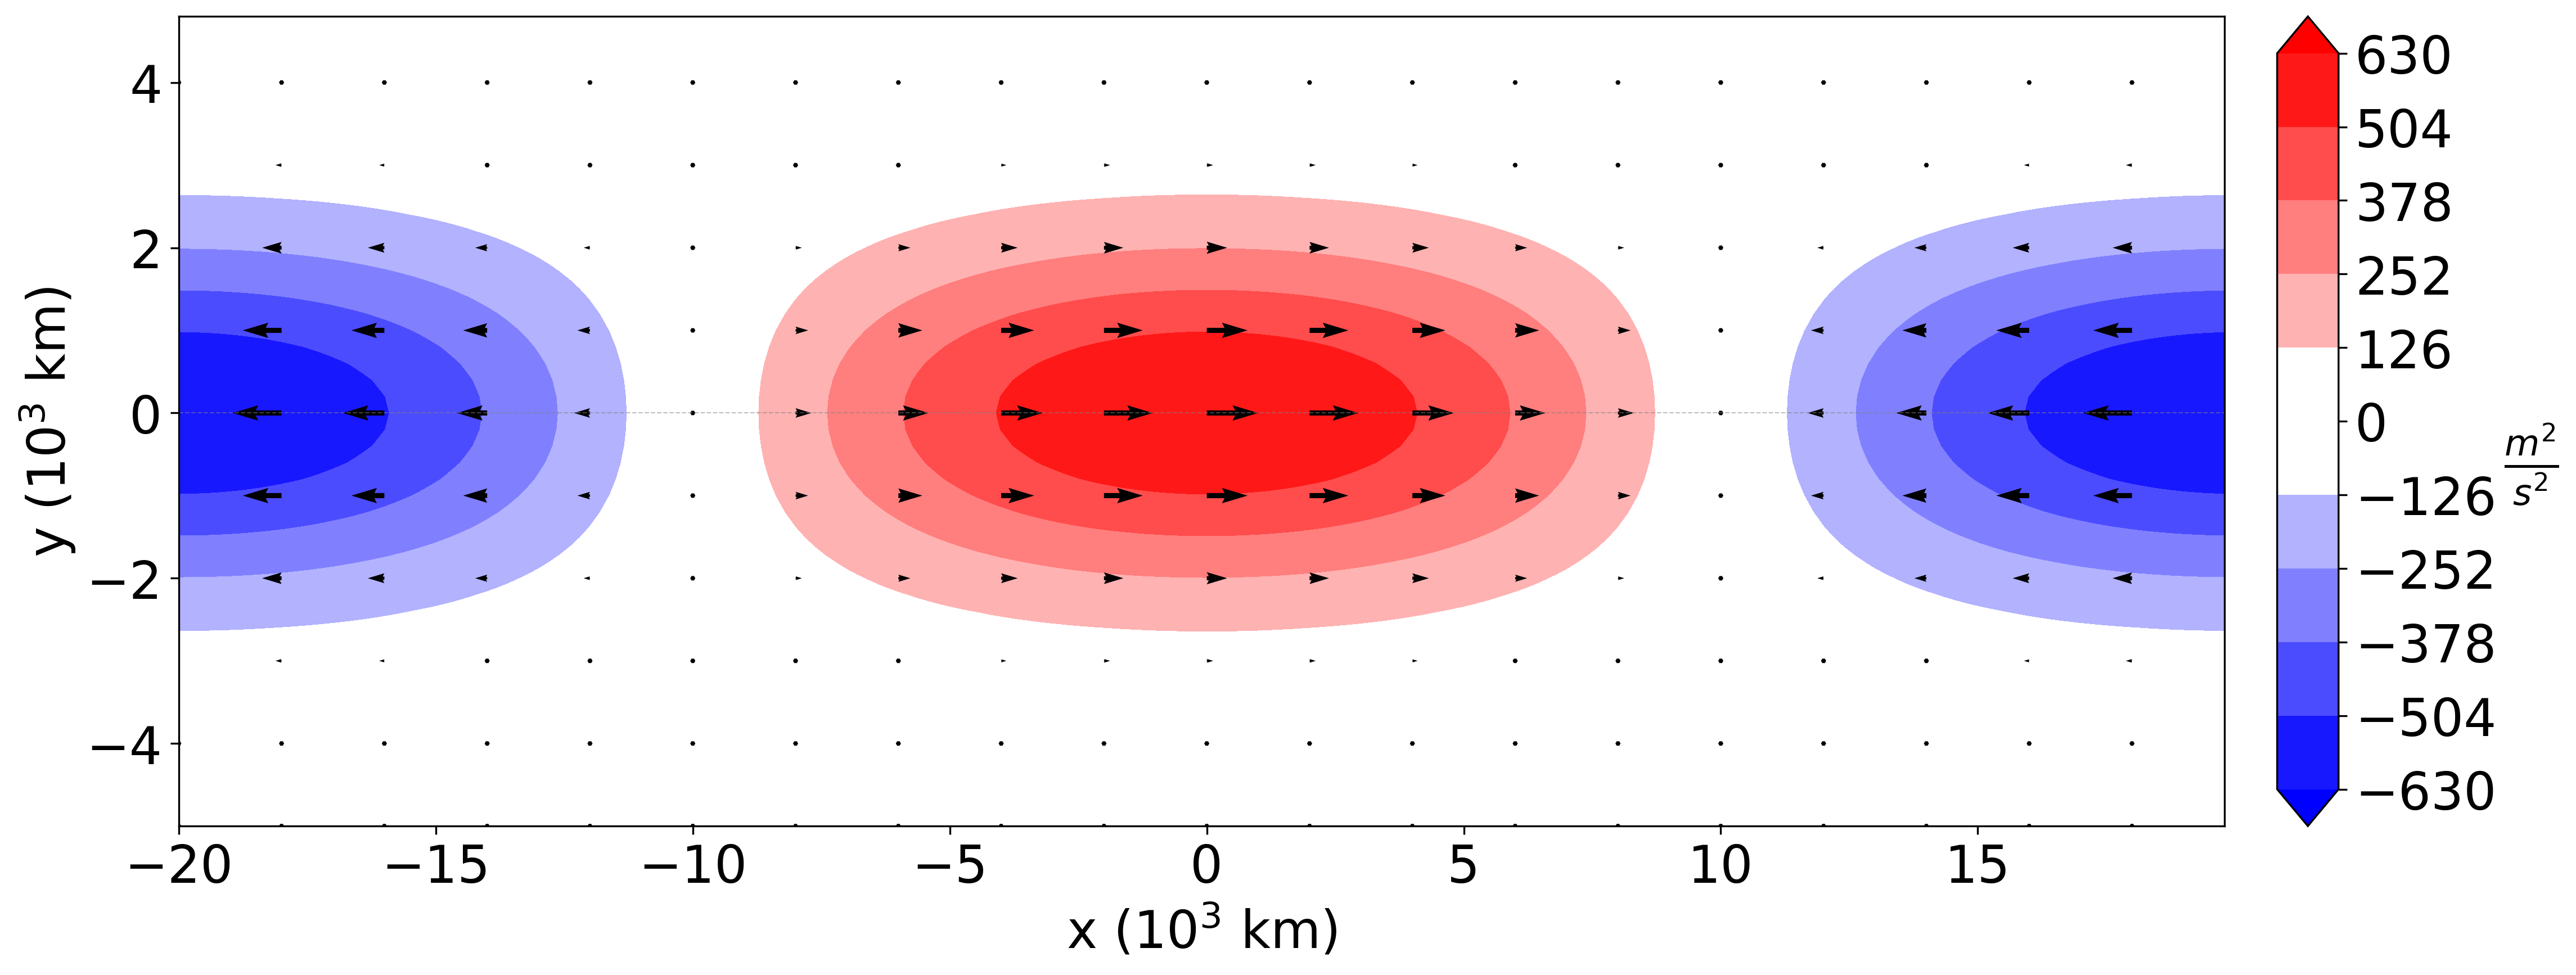

In [1080]:
plt.style.use('default')
plt.rcParams.update({'font.size':22})
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

contour_args = {
    'levels' :  np.linspace(
                    -np.max(np.abs(column_temperature[0])), 
                    np.max(np.abs(column_temperature[0])), 
                    11
                ),
    # 'levels' :  11,
    'norm'   :  mcolors.CenteredNorm(),
    'cmap'   :  modified_cmap, 
    'extend' :  'both'
}

quiver_scale = int(np.ceil(np.max(zonal_velocity[0])))

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,3], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05)

Tbar_ax = fig.add_subplot(gs[-1])
ax = fig.add_subplot(gs[0])

T_cont = ax.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    column_temperature[0],
    **contour_args
)

cbar = fig.colorbar(T_cont, cax=Tbar_ax)
cbar.set_ticks(contour_args['levels'])
cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)

# q_cont = plt.contour(
#     x_grid/1e6,
#     y_grid/1e6,
#     column_moisture[frame,:,:],
#     levels = np.delete(np.linspace(-0.5,0.5,11), [5]),
#     norm=mcolors.CenteredNorm(),
#     colors='black',
#     # alpha=0.5
# )
# qbar = fig.colorbar(q_cont, cax=qbar_ax)
# qbar_ax.yaxis.set_ticks_position('left')


quiv = ax.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[0][::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[0][::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 1.02,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('auto')

## Solve

In [1081]:
### Initialize leapfrog method with one step forward

### Transform to wavenumber space
ux_fft = fft(zonal_velocity[0,:,:],axis=1)
vy_fft = fft(meridional_velocity[0,:,:],axis=0)
Tx_fft = fft(column_temperature[0,:,:],axis=1)
Ty_fft = fft(column_temperature[0,:,:],axis=0)

### Compute derivatives
dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft
    
### Transform back to physical space
dudx = np.real(ifft(dudx_fft,axis=1))
dvdy = np.real(ifft(dvdy_fft,axis=0))
dTdx = np.real(ifft(dTdx_fft,axis=1))
dTdy = np.real(ifft(dTdy_fft,axis=0))

### Step forward one time step
zonal_velocity[1,:,:] = zonal_velocity[0,:,:] - time_step*(
    - CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[0,:,:] 
    + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdx[:,:]
)

meridional_velocity[1,:,:] = meridional_velocity[0,:,:] - time_step*(
    + CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[0,:,:] 
    + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdy[:,:]
)

column_temperature[1,:,:] = column_temperature[0,:,:] - time_step*(
    + gross_dry_stability*(dudx[:,:] + dvdy[:,:]) 
    # + temperature_sensitivity*(1+cloud_radiative_parameter)*column_temperature[0,:,:]
    # - moisture_sensitivity*(1+cloud_radiative_parameter)*column_moisture[0,:,:]
)

# column_moisture[1,:,:] = column_moisture[0,:,:] - time_step*(
#     # - zonal_moistening*zonal_velocity[0,:,:]
#     # + meridional_moistening*y_grid[:,None]*meridional_velocity[0,:,:] 
#     - gross_moisture_stratification*(dudx[:,:] + dvdy[:,:]) 
#     # - temperature_sensitivity*column_temperature[0,:,:]
#     # + moisture_sensitivity*column_moisture[0,:,:]
    
# )

### Meridional boundary condition
meridional_velocity[1,0,:] = 0.
meridional_velocity[1,-1,:] = 0.
        
### Step forward using leapfrong time-differencing
for it in tqdm(range(2,nt), position=0, leave=True, ncols=100):
    ### Transform to spectral space
    ux_fft = fft(zonal_velocity[it-1,:,:],axis=1)
    vy_fft = fft(meridional_velocity[it-1,:,:],axis=0)
    Tx_fft = fft(column_temperature[it-1,:,:],axis=1)
    Ty_fft = fft(column_temperature[it-1,:,:],axis=0)

    ### Compute derivatives
    dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
    dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

    ### Transform back to physical space
    dudx = np.real(ifft(dudx_fft,axis=1))
    dvdy = np.real(ifft(dvdy_fft,axis=0))
    dTdx = np.real(ifft(dTdx_fft,axis=1))
    dTdy = np.real(ifft(dTdy_fft,axis=0))

    ### Step forward with leapfrog scheme
    zonal_velocity[it,:,:] = (zonal_velocity[it-2,:,:] - 2*time_step*(
        - CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[it-1,:,:] 
        + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdx[:,:])
    )
    
    meridional_velocity[it,:,:] = (meridional_velocity[it-2,:,:] - 2*time_step*(
        + CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[it-1,:,:] 
        + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdy[:,:])
    )
    
    # column_temperature[it,:,:] = (1/(1+2*temperature_sensitivity*(1+cloud_radiative_parameter)*time_step))*(
    #     column_temperature[it-2,:,:] 
    #     - 2*time_step*(
    #         + gross_dry_stability*(dudx[:,:] + dvdy[:,:])
    #         # - moisture_sensitivity*(1+cloud_radiative_parameter)*column_moisture[it-1,:,:]
    #     )
    # )
    
    column_temperature[it,:,:] = (column_temperature[it-2,:,:] - 2*time_step*(
            + gross_dry_stability*(dudx[:,:] + dvdy[:,:])
            # - moisture_sensitivity*(1+cloud_radiative_parameter)*column_moisture[it-1,:,:]
        )
    )
    
#     column_moisture[it,:,:] = (1/(1+2*moisture_sensitivity*time_step))*(
#         column_moisture[it-2,:,:] 
#         - 2*time_step*(
#             # - zonal_moistening*zonal_velocity[it-1,:,:]
#             # + meridional_moistening*y_grid[:,None]*meridional_velocity[it-1,:,:] 
#             - gross_moisture_stratification*(dudx[:,:] + dvdy[:,:])
#             # - temperature_sensitivity*column_temperature[0,:,:]
#         )
#     )
    
    ### Meridional boundary condition
    meridional_velocity[it,0,:] = 0.
    meridional_velocity[it,-1,:] = 0.

100%|██████████████████████████████████████████████████████████| 8190/8190 [00:14<00:00, 554.99it/s]


## Plot Solutions

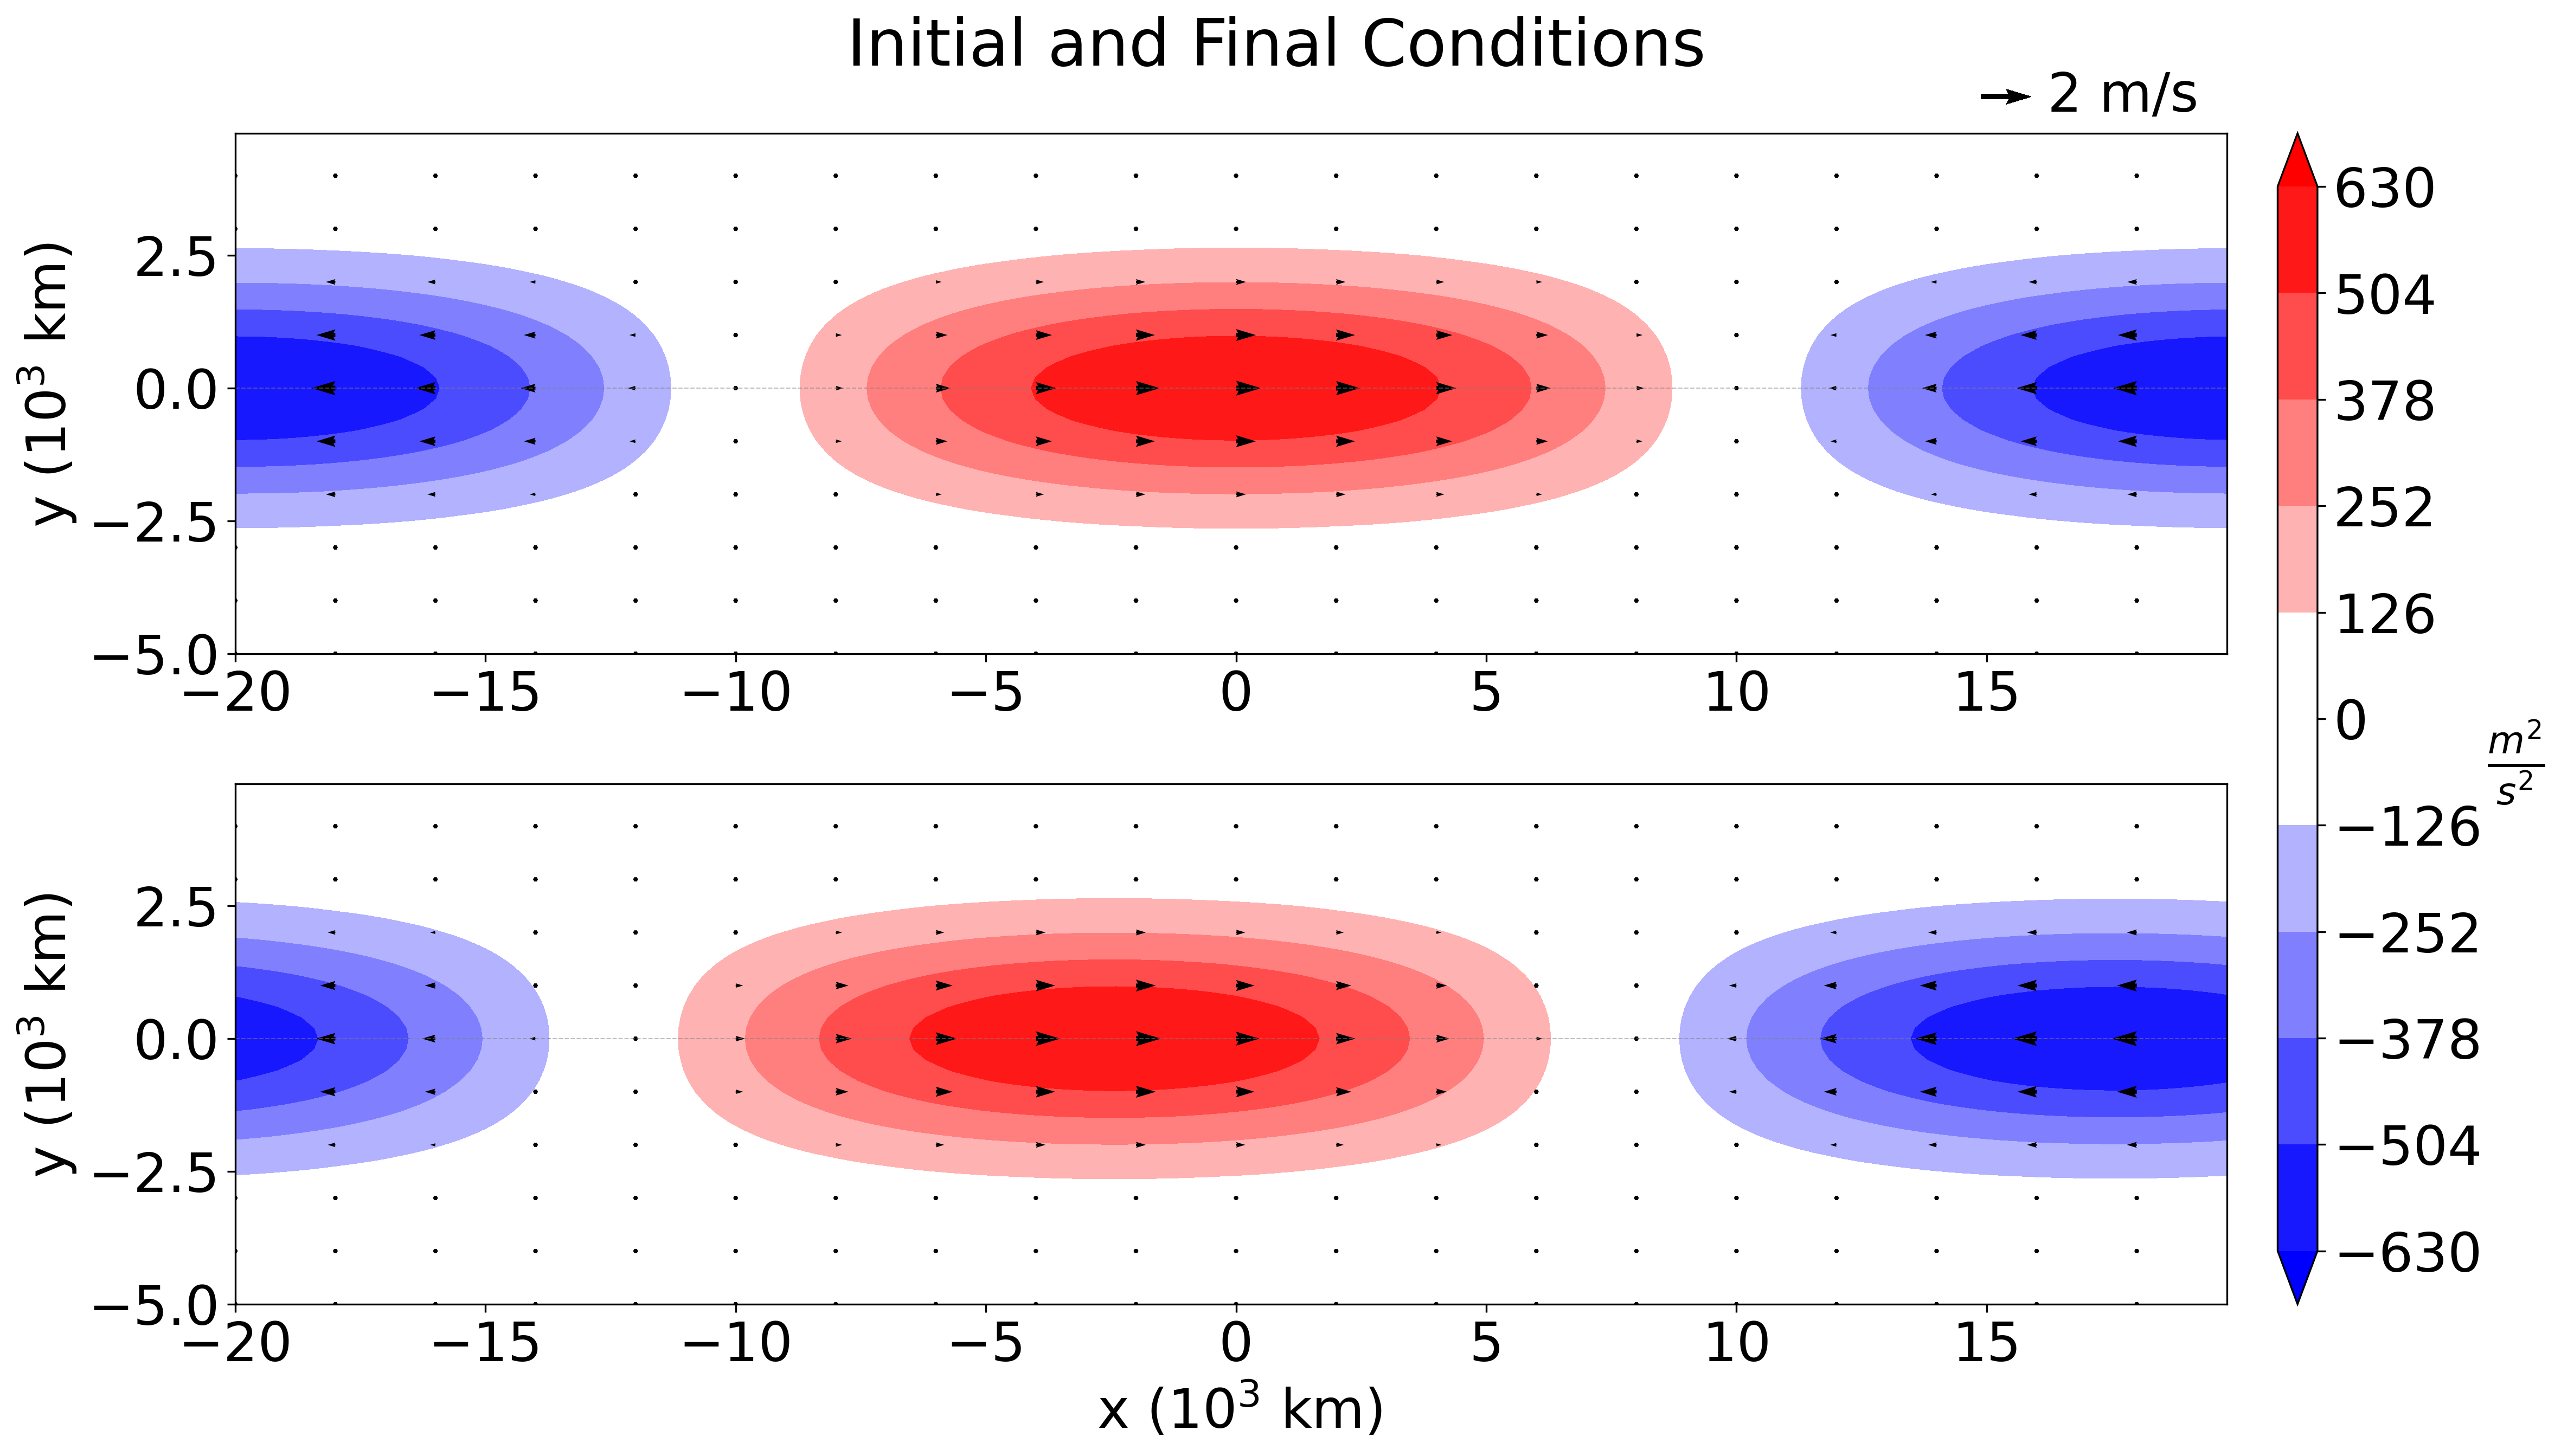

In [1082]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
grid_scaling = 1e-6
quiver_scale = int(np.ceil(np.max(zonal_velocity)))
end_frame = -1000

contour_args = {
    # 'levels' : np.arange(
    #                -np.around(gravity_wave_phase_speed, 0), 
    #                np.around(gravity_wave_phase_speed, 0)+10, 
    #                10
    #            ),
    'levels' : np.linspace(np.min(column_temperature), np.max(column_temperature), 11),
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,9),dpi=300)
gs = GridSpec(2, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

# Label figure
fig.suptitle('Initial and Final Conditions')

#### Initial Condition ####
# Add for the initial condition
cbar_ax = fig.add_subplot(gs[:, -1])
ax0 = fig.add_subplot(gs[0, 0])

# Plot contours of geopotential height anomalies
cont = ax0.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    column_temperature[0],
    **contour_args
)

cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)

# Plot vectors of wind anomalies
quiv = ax0.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[0,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[0,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

# Add a key for the wind vectors
ax0.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line on the equator
ax0.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label y axis
ax0.set_ylabel(r" y (10$^{3}$ km)")

# Set the plot aspect
ax0.set_aspect('auto')
#########################

#### Final Condition ####
# Add axes for final condition
ax1 = fig.add_subplot(gs[1, 0])

# Geopotential Height contours
cont1 = ax1.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    column_temperature[end_frame],
    **contour_args
)

# Wind vectors
quiv1 = ax1.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[end_frame,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[end_frame,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

# Equator line
ax1.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label axes
ax1.set_xlabel(r" x (10$^{3}$ km)")
ax1.set_ylabel(r" y (10$^{3}$ km)")

# Aspect ratio
ax1.set_aspect('auto')

## Filtered Solutions

In [17]:
cutoff_days = 20

low_u = mjo.butter_lowpass_filter(zonal_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_v = mjo.butter_lowpass_filter(meridional_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_T = mjo.butter_lowpass_filter(column_temperature.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_q = mjo.butter_lowpass_filter(column_moisture.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T

In [18]:
# phase_speed = np.einsum('i,j->ikj', zonal_wavenumber, frequencies)
frequencies = np.fft.fftfreq(len(time), 1/time_step)
phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(y_grid), axis=1)

u_fft = np.fft.fft2(low_u, axes=[0,2])
u_fft[np.where(phase_speed<=0)] = 0
u_east = np.real(np.fft.ifft2(u_fft, axes=[0,2]))

v_fft = np.fft.fft2(low_v, axes=[0,2])
v_fft[np.where(phase_speed<=0)] = 0
v_east = np.real(np.fft.ifft2(v_fft, axes=[0,2]))

T_fft = np.fft.fft2(low_T, axes=[0,2])
T_fft[np.where(phase_speed<=0)] = 0
T_east = np.real(np.fft.ifft2(T_fft, axes=[0,2]))

q_fft = np.fft.fft2(low_q, axes=[0,2])
q_fft[np.where(phase_speed<=0)] = 0
q_east = np.real(np.fft.ifft2(q_fft, axes=[0,2]))
# plt.contourf(np.real(test)[0,:,:], cmap='coolwarm', norm=mcolors.CenteredNorm())

In [10]:
# # q_fft = np.fft.fft2(low_q, axes=[0,2])
# mask = np.zeros_like(low_u)
# mask[:,:,10] = 1

# u_fft = np.fft.fft2(low_u, axes=[0,2])
# u_fft_masked = u_fft*mask
# u_1 = np.real(np.fft.ifft2(u_fft_masked, axes=[0,2]))

# v_fft = np.fft.fft2(low_v, axes=[0,2])
# v_fft_masked = v_fft*mask
# v_1 = np.real(np.fft.ifft2(v_fft_masked, axes=[0,2]))

# T_fft = np.fft.fft2(low_T, axes=[0,2])
# T_fft_masked = T_fft*mask
# T_1 = np.real(np.fft.ifft2(T_fft_masked, axes=[0,2]))

# q_fft = np.fft.fft2(low_q, axes=[0,2])
# q_fft_masked = q_fft*mask
# q_1 = np.real(np.fft.ifft2(q_fft_masked, axes=[0,2]))

## Animation

 98%|█████████████████████████████████████████████████████████████▊ | 50/51 [00:52<00:01,  1.60s/it]

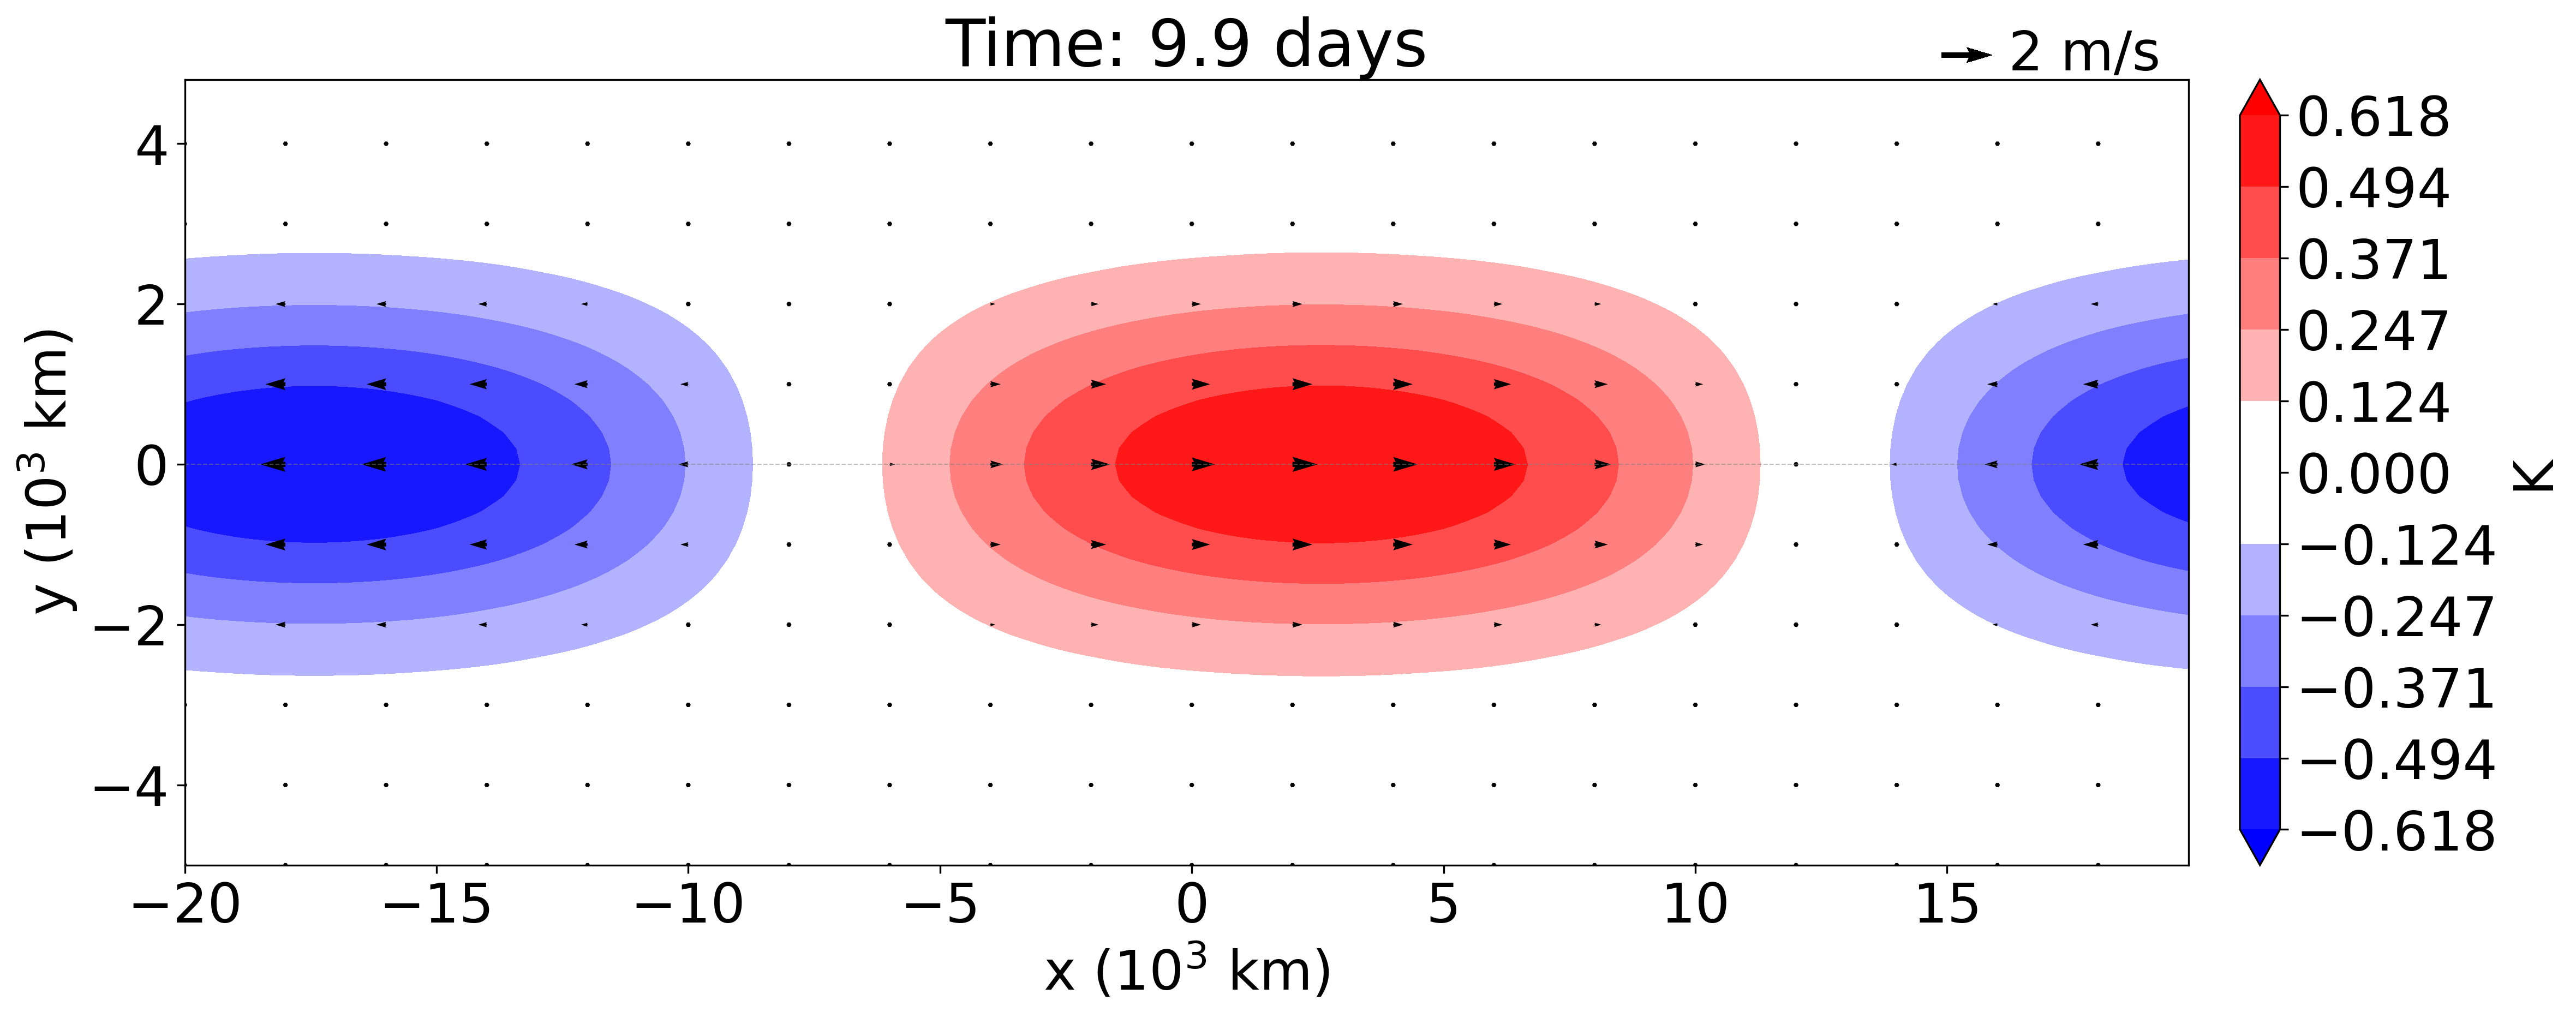

In [1088]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})

n_frames = 50
starting_frame = 0
frame_interval = int((nt - starting_frame)/n_frames)
frames = np.arange(starting_frame, nt, frame_interval)

quiver_scale = int(np.ceil(np.max(zonal_velocity)))
grid_scaling = 1e-6

column_integrated_mass = 1000*10/9.8 

contour_args = {
    # 'levels' : np.arange(
    #                -np.around(gravity_wave_phase_speed, 0), 
    #                np.around(gravity_wave_phase_speed, 0)+10, 
    #                10
    #            ),
    'levels' : np.linspace(np.min(column_temperature/column_integrated_mass), np.max(column_temperature/column_integrated_mass), 11),
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time[starting_frame]/SECONDS_PER_DAY:0.1f} days")

cont = ax.contourf(
    x_grid*grid_scaling,
    y_grid*grid_scaling,
    column_temperature[starting_frame]/column_integrated_mass,
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_label(f"K")
cbar.set_ticks(contour_args['levels'])

quiv = ax.quiver(
    x_grid[::x_plot_spacing]*grid_scaling,
    y_grid[::y_plot_spacing]*grid_scaling,
    zonal_velocity[starting_frame,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[starting_frame,::y_plot_spacing,::x_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('auto')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

def update(current_frame):
    
    # plotting_index = starting_frame + frame_interval*current_frame
    plotting_index = current_frame
    
    ax.set_title(f"Time: {time[plotting_index]/SECONDS_PER_DAY:0.1f} days")
    cont = ax.contourf(
        x_grid*grid_scaling,
        y_grid*grid_scaling,
        column_temperature[plotting_index]/column_integrated_mass,
        **contour_args
    )
    quiv = ax.quiver(
        x_grid[::x_plot_spacing]*grid_scaling,
        y_grid[::y_plot_spacing]*grid_scaling,
        zonal_velocity[plotting_index,::y_plot_spacing,::x_plot_spacing],
        meridional_velocity[plotting_index,::y_plot_spacing,::x_plot_spacing],
        **quiver_args
    )
    return cont, quiv
    
anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

anim_dir = r"/home/disk/eos7/sressel/Research/Code/graphics/"
anim_file_name = f"Ahmed_k={initial_wavenumber}_{initial_wave}_wave.mp4"
anim.save(anim_dir + anim_file_name, dpi=300)